<a href="https://colab.research.google.com/github/gbeyderman/gbeyderman/blob/gh-pages/Airbnb_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling the Price of Airbnb Listings:

### Gamliel Beyderman, Peter Le, Olivia Sarver, David Wu, Nazanin Yari, Kei Yuen

 


# 1) Introduction

Abstract:

Everyone knows Airbnb.  It has been increasingly gaining popularity since 2008 due to its moderate prices and the plentiful supply of often orignal, classy dwellings for a short-term rental. This project involves a detailed Exploratory Data Analysis (EDA), followed by a number of iterations of Linear Regression and two machine learning models to identify the key factors affecting Airbnb listing prices using data describing the listing activity and metrics in New York City for 2019 (https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). The dataset contains almost 50 thousand unique listings. Since the city no longer exists (some local politics there from a hardened Brooklynite), everyone is now a New Yorker - we were all excited to try our new shiny Data Science toolkit to predict the price of listings based on the available data.

The results showed that for a rather rudimentary set of 13 variables one of which is free text, one is a date, 3 categorical, and the rest numeric, most inreases in model quality came from new feature engineering followed by variable transformation. For linear regression we were able to improve $R^2$ from 20% to almost 70%. It was cool to note that the consistent decrease in listing price that came with an increase in the distance from Midtown Manhattan, a tourism hub. Parsing the free text field for basic listing amenities was also quite successful.

## Project Structure
This project is structured as follows: 


1.   Introduction
2.   EDA
3.   Linear Regression Model
4.   Model Evaluation
5.   Machine Learning Models

 

**Data Dictionary**:

The original Kaggle dataset featured the following variables:
* Name of the Listing - a free text field with values such as "Clean & quiet apt home by the park"
* Neighborhood Group - a categorical variable specifying the 1 of 5 NYC boroughs (Brooklyn, Queens, Mahnattan...)
* Neighborhood - a categorical variable pinpointing the specific neighborhood such as 'Midtown' or 'Harlem'
* Room Type - a vetagorical variable describing the type of listing being offered ('Shared Room','Private Room','Entire Home')
* Last Review - a date field showing the when the last review was submitted by guests
* Latitude, Longitude - geographic coordinates of the listing allowing us to calculate the geographic distnace between the listing and the perceived tourism center.
* Price - listing price, our dependent variable.
* Minimum Nights - the least number of nights the host is willing to committ.
* Number of Reviews - the number of times the guests were willing to submit a review about their experience.
* Reviews Per Month - an aggregate field showing the the mean number of reviews for the months the listing was active.
* Calculated Listings Count - the number of other listings offered by the host.
* Avalability 365 - the number of days when listing is available for booking

In [ ]:


import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from pandas.core.algorithms import value_counts
from pandas.core.reshape.concat import concat
import random
import patsy

sns.set(style="whitegrid")

In [ ]:
!pip install httpimport

In [ ]:
import httpimport
with httpimport.remote_repo(['models'], 'https://raw.githubusercontent.com/gbeyderman/datasharing/master'):
  import models

In [ ]:
df = pd.read_csv( "https://raw.githubusercontent.com/gbeyderman/datasharing/master/AB_NYC_2019.csv", header=0)

# 2a) EDA

### Price

Here, we are going to perform EDA on the `price` variable. `price` is a numerical variable that indicates how much money in dollars that a tenant will have to pay the host in order to live at their AirBnB location for one day. First, let's look at some descriptive statistics. 

In [ ]:
df.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

Here, we can see that the minimum value is 0 (which is in itself odd, and we should look further in the future). The maximum value is \$10,000, which is also odd. 25% of the listings have a price of \$69 or less, half of the listings have a price of \$106 or less, and 75% of the listings have a price of \$175 or less. 

These prices, less the odd outliers, seem fairly consistent with what we expect with the AirBnB business model and hospitality in general. One pays around \$50 to \$200 dollars a night to have lodgings. 

Let's plot the distribution to see if there are any underlying structures to this variable.

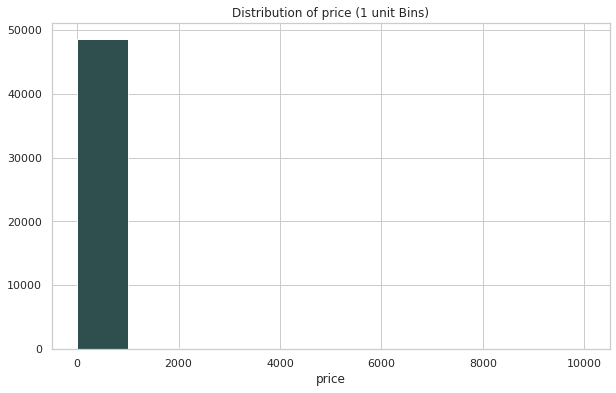

In [ ]:


figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df.price, color="darkslategray")
axes.set_title("Distribution of price (1 unit Bins)")
axes.set_xlabel("price")

plt.show()
plt.close()

It is obvious that there are outliers within the data that are preventing us from seeing any meaningful structures within this variable. Let's look at a boxplot to see if we can pluck out what a good range would be for us to zoom in to this graph with.

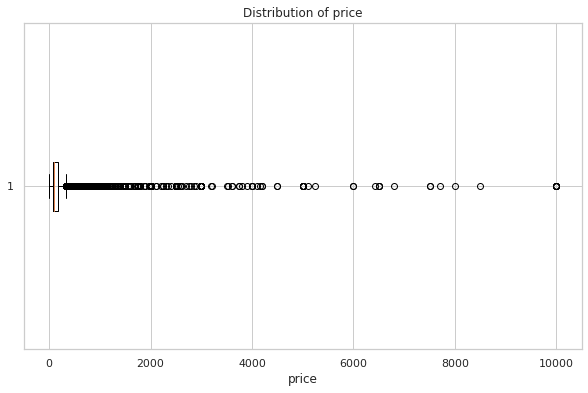

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.boxplot(df.price, vert=False)
axes.set_title("Distribution of price")
axes.set_xlabel("price")

plt.show()
plt.close()

We can see from this box plot that the more "reasonable" place to look for AirBnB listing prices are well under \$1000. This falls in place with common sense –– it is rather improbable that one would pay more than \$1000 to stay one night in a residence. Certainly, there are luxury rentals that encompass that price range, but so far we would not be well served missing the forest for the trees. We should table the extremely high prices for now, and zoom in on the lower end of the spectrum to get a better idea of the distribution of this variable.

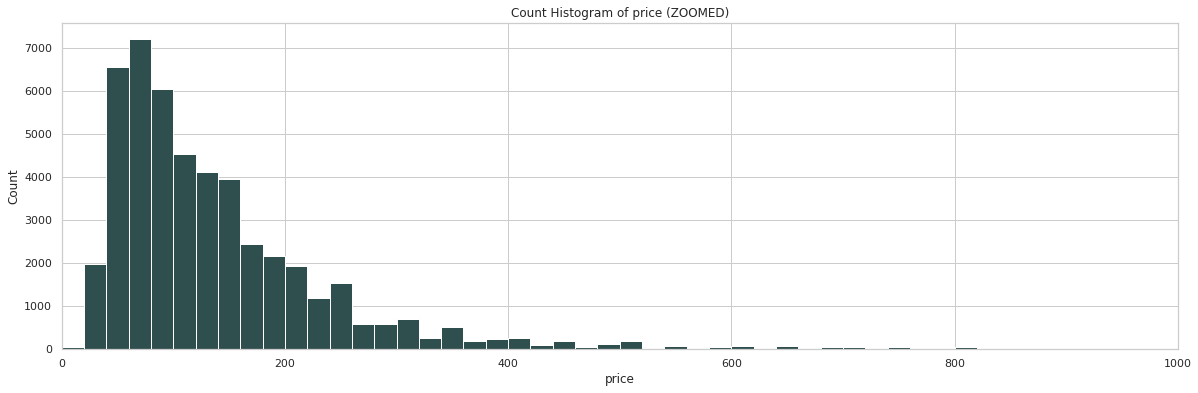

In [ ]:
feature = "price"

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df.price, bins = 500, color="darkslategrey")
axes.set_xlabel(feature)
axes.set_ylabel("Count")
axes.set_title("Count Histogram of " + feature + ' (ZOOMED)')
axes.set_xlim(0, 1000)

plt.show()
plt.close()

Here we can see a histogram that is more reasonable. There is a rather large peak in the beginning around the \$50 to \$150 range. From there, there are relatviely fewer and fewer listings at higher prices. 

Since an AirBnB listing having a price of $0 seems rather suspicious, we will be looking into it more and perhaps determine what can be done about it. Let's investigate some of the listings with a price of \$0.

In [ ]:
price_0 = pd.DataFrame (df[df.price == 0].sort_values(by=['price']))

price_0.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
23161,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,2018-01-06,0.05,4,28
25433,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,2019-06-24,2.56,4,127
25634,20523843,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",15787004,Martial Loft,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,2019-05-18,0.71,5,0
25753,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,2017-10-27,0.53,2,0
25778,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,2018-01-02,0.15,1,73


Let's count how many of these errant listings we have, also:

In [ ]:
price_0.count()

id                                11
name                              11
host_id                           11
host_name                         11
neighbourhood_group               11
neighbourhood                     11
latitude                          11
longitude                         11
room_type                         11
price                             11
minimum_nights                    11
number_of_reviews                 11
last_review                       10
reviews_per_month                 10
calculated_host_listings_count    11
availability_365                  11
dtype: int64

None of the other variables within the listings of a price of \$0 seem to have any issues with them. A few of these listings are accessible even now –– a quick serach of ["MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)"](https://www.airbnb.com/rooms/20523843?source_impression_id=p3_1620628836_n%2Boqg8lcU3gcbuXx) brings up a listing that has a non-zero price amount. Of course, this could've been changed between now and the time that this data was mined, but searches into any of the other listings (that are still up) reveal that none of them actually have a price of \$0. From this, we can rather reliably conclude that the price for these listings do not accurately reflect what they actually were. 

Based on how few of these listings there are (11 out of 48895), it is probably safe to remove these. 

Let's try to remove them and then look at the descriptive statistics to see if their removal has any great impact; it will likely not.



In [ ]:
price_Non0 = pd.DataFrame (df[df.price != 0].sort_values(by=['price']))

price_Non0_Des =  pd.DataFrame (price_Non0['price'].describe())

price_Non0_Des

,price
count,48884.000000
mean,152.755053
std,240.170260
min,10.000000
25%,69.000000
50%,106.000000
75%,175.000000
max,10000.000000


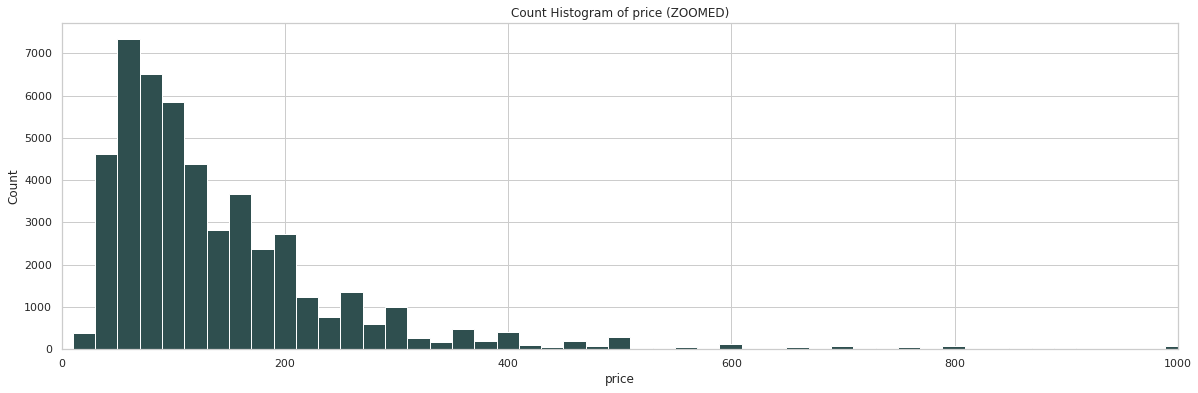

In [ ]:
feature = "price"

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(price_Non0[feature], bins = 500, color="darkslategray")
axes.set_xlabel(feature)
axes.set_ylabel("Count")
axes.set_title("Count Histogram of " + feature + ' (ZOOMED)')
axes.set_xlim(0, 1000)

plt.show()
plt.close()

There was little to no change in standard deviation and mean to the price variable, when removing the 0. The histogram also appears very similar. 


Based on the information seen from this work, it might be worth removing all of the 0 values from the dataset. We know with some degree of reliability that these prices do not reflect the true prices of the listings. Furthermore, it would make certain transformations more useful in the future. 

### Calculated_Host_Listings_Count

Here, EDA will be conducted on the `calculated_host_listings_count` variable. First, let's look at some descriptive statistics to get a sense of the distribution of the data. 

In [ ]:
df.calculated_host_listings_count.describe()

count    48895.000000
mean         7.143982
std         32.952519
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64

`calculated_host_listings_count` is a numerical variable, it represents the total number of listing for the host, the minimum is 1 and maximum is 327 and the mean is 7. 50% of the observed listings within this dataset have 1 listing, and 75% of the observed listings within the dataset have 2 listings or fewer. The maximum number of listings seen is 327, which indicates that there are most likely outliers within this dataset. 

To get a finer sense of what this entails, we should look at the individual counts.

In [ ]:
df.calculated_host_listings_count.value_counts().sort_index()

1      32303
2       6658
3       2853
4       1440
5        845
6        570
7        399
8        416
9        234
10       210
11       110
12       180
13       130
14        70
15        75
16        16
17        68
18        54
19        19
20        40
21        21
23        69
25        50
26        26
27        27
28        56
29        29
30        30
31        62
32        32
33        99
34        68
37        37
39        39
43        43
47        47
49        98
50        50
52       104
65        65
87        87
91        91
96       192
103      103
121      121
232      232
327      327
Name: calculated_host_listings_count, dtype: int64

We can see that 32303 listings within this dataset have only 1 listing, and 6658 have 2 listings. We can also see that the value counts for some of the higher values match exactly with the host listing count. In other words, if we see a 327 listings with a `calculated_host_listings_counut` of 327, it makes sense that it is the same host (otherwise, the number would necessarily be some multiple of `calculated_host_listings_count` at that value. This also means, in other words, there are 3329 hosts with 2 listings, 951 hosts with 3 listings, and so on. 

Let's visualize the data within a box plot to see if there are any inferences we can draw that were not already clear. 

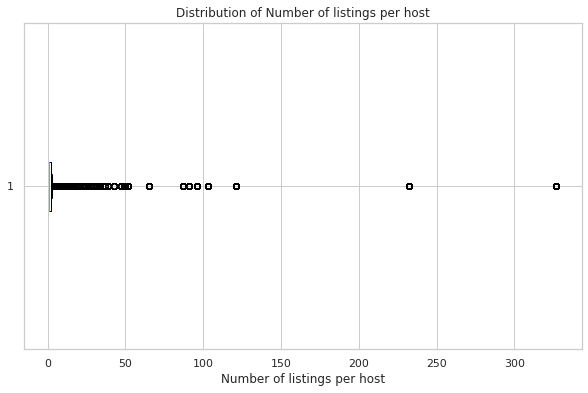

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.boxplot(df.calculated_host_listings_count,vert=False)
axes.set_title("Distribution of Number of listings per host")
axes.set_xlabel("Number of listings per host")
plt.show()
plt.close()

This boxplot is not very informative, but it does reinforce what we understood earlier. We see that the boxplot is almost entirely squashed into 1 and 2, with multiple outliers past it. 

As we are performing this EDA with the goal of prediction in mind, it is probably more useful to use this variable as a categorical one rather than a numerical variable. What we see from cursory EDA is that the vast majority of listings are from hosts who own only one property. Above that, there are a few hosts who have a handful of properties, but beyond there are hosts who have an extreme number of properties, to the point of numbering in the hundreds. Thus, for this variable, we're going to group the data into buckets. Listings from hosts who have only one property, listings from hosts who have two to ten properties, and listings from hosts who have over ten properties.  


Convert calculated_host_listings_count to categorical variable: low when count =1; average when count from 2 to 9, high when count >10

In [ ]:
df["host_experience"] = "average"
df.loc[(df["calculated_host_listings_count"]<2),"host_experience"] = "low"
df.loc[(df["calculated_host_listings_count"]>10),"host_experience"] = "high"
df = pd.concat([df, pd.get_dummies(df["host_experience"], prefix="host_experience")], axis=1)

 ### availability_365

Here we are going to perform EDA on `availability_365`. This variable represents the number of days that are available for booking on the listing. It is a numeric variable that ranges from 0 to 365, the maximum allowed being a whole year. 

Let's look at some descriptive statistics first to get a sense of the distribution of the data. 

In [ ]:
df.availability_365.describe()

count    48895.000000
mean       112.781327
std        131.622289
min          0.000000
25%          0.000000
50%         45.000000
75%        227.000000
max        365.000000
Name: availability_365, dtype: float64

We can see that 25% of the data are at 0 available days., 50% of the data are 45 days are fewer, 75% of the data are at 227 days or fewer. The average is around 112 days. Let's look at the individual counts to see a finer view.

In [ ]:
df.availability_365.value_counts().sort_index()

0      17533
1        408
2        270
3        306
4        233
       ...  
361      111
362      166
363      239
364      491
365     1295
Name: availability_365, Length: 366, dtype: int64

We can see that there are 17533 listings with 9 days of availability. This accounts for over a third of all of the listings in the observed dataset. Let us plot a histogram of the disttribution of this variable to get a sense of the structure.

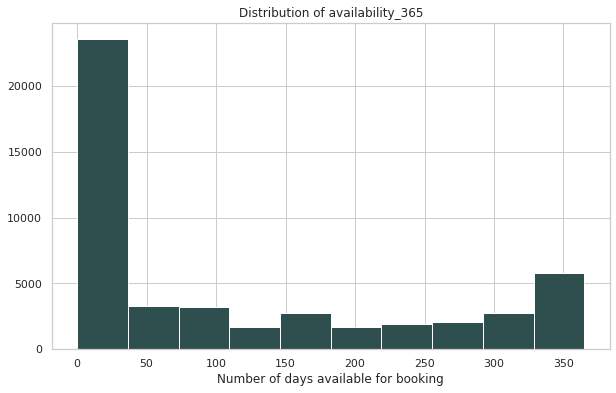

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df.availability_365, color="darkslategray")
axes.set_title("Distribution of availability_365")
axes.set_xlabel("Number of days available for booking")

plt.show()
plt.close()

We can see that the first bin absolutely dominates the dataset. The vast majority of listings have only a handful of days available for booking; relatively fewer listings have their number of available days higher than this bucket. Let us try to view the distribution in finer detail. Given what we know from simply looking at the descriptive statistics, we know that one possible value (0 days) takes up over a third of all the listings –– this is rather suspicious. 

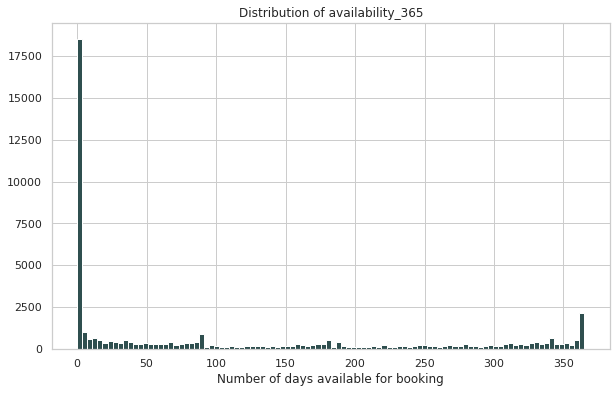

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df.availability_365, color="darkslategray",bins=100)
axes.set_title("Distribution of availability_365")
axes.set_xlabel("Number of days available for booking")

plt.show()
plt.close()

At the day level of detail, the picture becomes a little more clear. This is an extremely uneven distribution. There could be a variety of explanations of why these listings have 0 days available; it could be the case that these listings may not be credible, or it could be the case that these listings are so popular that they are constantly booked out. At any rate, they represent a significant enough proportion of the observations within the dataset that these listings may share some commonalities of interest that are relevant to predictions later. 

## Neighborhood and Neighborhood_Group

Here we are going to perform EDA on the `neighborhood` variable. `neighborhood` is a string representing the neighborhood that the AirBnB listing is situated in. Contrasted with boroughs like Brooklyn or Manhattan, these are the more specific neighrbodhoods like Harlem or Bed-Stuy.

First, let's look at some descriptive statistics in terms of the relative proportions of the neighborhoods in the dataset. 

In [ ]:
df.neighbourhood.value_counts(normalize=True)

Williamsburg          0.080169
Bedford-Stuyvesant    0.075894
Harlem                0.054374
Bushwick              0.050364
Upper West Side       0.040320
                        ...   
Woodrow               0.000020
Richmondtown          0.000020
New Dorp              0.000020
Rossville             0.000020
Fort Wadsworth        0.000020
Name: neighbourhood, Length: 221, dtype: float64

Just one Brooklyn neighborhood of Williamsburg represents over 8% of all the listings. 13 neighborhoods had over 1000 listings; over 50 had under 10. Assumedly, the places with most rentals were the most appealing to tourists, and the closest to Manhattan where most of the tourist sites are.

In [ ]:
df.neighbourhood_group.value_counts(normalize=True)

Manhattan        0.443090
Brooklyn         0.411075
Queens           0.115907
Bronx            0.022298
Staten Island    0.007630
Name: neighbourhood_group, dtype: float64

Interesting to note that over 80% of the listings are in Manhattan and Brooklyn alone!

##Last Review

Last review is an ordinal variable which indicates the date of the last review for a given host. There are 38,843 values of last review, with 10,052 missing values. At best, we can see some of the value counts for this variable.

In [ ]:
df.last_review.value_counts()

2019-06-23    1412
2019-07-01    1359
2019-06-30    1341
2019-06-24     874
2019-07-07     718
              ... 
2014-09-12       1
2015-06-13       1
2014-04-27       1
2011-05-12       1
2013-09-11       1
Name: last_review, Length: 1764, dtype: int64

In order the show the date range, we first need to remove the rows with missing values:

In [ ]:
df_no_missing = df.dropna()

In [ ]:
print("The range of the last review dates are: ", df_no_missing.last_review.min(), "through", df_no_missing.last_review.max())

The range of the last review dates are:  2011-03-28 through 2019-07-08


The dates of the last review range from 2011 all the way to 2019. It is unclear what motivates certain reviewers to review a listing, or even when they do it. Perhaps this deals with the age of the listing, or perhaps an experience was so good that the tenant had no choice but to comment on the listing. To utilize this variable certain transformations would have to be made on it, possibly having to do with how long it has been since the listing was last reviewed. However, given that there is no way of reliably knowing when this data was mined, the decision was made to not include this variable within the final model. 

## Reviews Per Month

Reviews per month is a numeric variable and it represents the total number of reviews per month for a given host. We might expect that this variable has a positive relationship with the target variable, price. Although, it can also include negative reviews as well. 

Let's first look at the summary statistics for Reviews per Month to get a sense for the range and see if there is any missing values, or anomolies. 

In [ ]:
Tukeys_five = df["reviews_per_month"].describe()
Tukeys_five

count    38833.000000
mean         1.373128
std          1.680391
min          0.010000
25%          0.190000
50%          0.720000
75%          2.020000
max         58.500000
Name: reviews_per_month, dtype: float64

The total count is 38843 which indicates that there are 10,052 missing values that needs to be handled.

The minimum number of reviews per month is 0.01, and the maximum is 58.5. The average number of reviews per month is 1.37 which is higher than median of 0.72. This suggests a right skewness. Furtheremore, 75% of the data is below 2.02 which is significanly different from the max of 58.5.

The dispersion metrics are as below:

In [ ]:
print("Q1-Q2: {:.3f}".format(Tukeys_five["50%"] - Tukeys_five["25%"]))
print("Q2-Q3: {:.3f}".format(Tukeys_five["75%"] - Tukeys_five["50%"]))

Q1-Q2: 0.530
Q2-Q3: 1.300


In [ ]:
def ex(stats, stat):
    return stats.loc[[stat]].values[0]

print("Range=", ex(Tukeys_five, "max") - ex(Tukeys_five, "min"))
print("IQR =", ex(Tukeys_five, "75%") - ex(Tukeys_five, "25%"))
print("COV =", ex(Tukeys_five, "std")/ex(Tukeys_five, "mean"))

Range= 58.49
IQR = 1.83
COV = 1.2237686543009059


Because the difference between the median and the first quartile is less than the difference between the median and the third quartile, the distribution is skewed.

Let's take a look at the value counts:

In [ ]:
x = pd.DataFrame(df.reviews_per_month.value_counts().sort_index())
x

,reviews_per_month
0.01,42
0.02,919
0.03,804
0.04,655
0.05,892
...,...
17.82,1
19.75,1
20.94,1
27.95,1


This variable is numerical so we can do a histogram. 

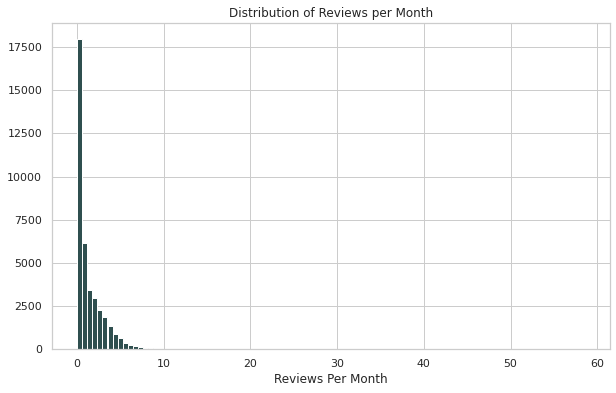

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df.reviews_per_month, color="darkslategray", bins=100)
axes.set_title("Distribution of Reviews per Month")
axes.set_xlabel("Reviews Per Month")

plt.show()
plt.close()

As shown in the plot, 75% of the data is below around 2. 

In [ ]:
print(x[(x.index > 11)])

       reviews_per_month
11.03                  1
11.14                  1
11.16                  1
11.17                  1
11.21                  1
11.25                  1
11.38                  1
11.40                  1
11.56                  1
11.59                  2
11.68                  1
11.71                  1
11.72                  1
11.84                  1
11.91                  1
12.00                  2
12.05                  2
12.11                  1
12.12                  1
12.54                  1
12.84                  1
12.99                  1
13.11                  1
13.13                  1
13.15                  1
13.24                  1
13.27                  1
13.30                  1
13.33                  1
13.40                  1
13.42                  1
13.45                  1
13.48                  1
14.00                  2
14.36                  1
14.58                  1
14.62                  1
15.23                  1
15.32                  1


There are just a few (compared to total 48895 observations) listings with more than 11 reviews per month. 

## Latitude and Longitude

Here we are going to perform EDA on the variables `latitude` and `longitude`. These are the positional coordinates for the listing. Since all of these are in New York, we might actuall y be able to use these two variables to make a literal map of New York!

Before we dive in, we know that the latitude and longitude for the listings will most likely group them into the various neighborhoods and boroughs of New York, and likely not be able to be represented using any mathematical distributions. Also, since the dataset itself is comprised of AirBnB listings only from New York, there will probably not be any drastic changes in these variables. As such, these variables may require baselining.

First let us start with the latitude variable. We are going to look at some descriptive statistics.


In [ ]:
df.latitude.describe()

count    48884.000000
mean        40.728953
std          0.054532
min         40.499790
25%         40.690100
50%         40.723080
75%         40.763120
max         40.913060
Name: latitude, dtype: float64

The [latitude marker](https://www.latlong.net/place/new-york-city-ny-usa-1848.html) for NYC is around 40 N (positive is N). Since the minimum value is 40.499, it doesn't seem like there are any missing values or zeroes, meaning it's probably pretty useable as a comparable value.
Let's see how the data is distributed about the city in a histogram.

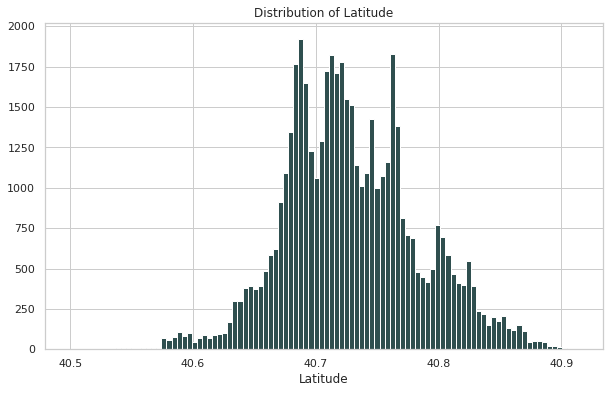

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df.latitude, color="darkslategray", bins=100)
axes.set_title("Distribution of Latitude")
axes.set_xlabel("Latitude")

plt.show()
plt.close()

The Latitude is distributed fairly normally, which is actually kind of interesting. I can see local peaks that most likely correspond with a neighborhood, it looks like the northern and southernmost parts of the data are less populated, which makes sense since most AirBnBs would be in the middle of the city. 

I'll do the same for Longitude now and expect it to look pretty similar.

In [ ]:
df.longitude.describe()

count    48884.000000
mean       -73.952176
std          0.046159
min        -74.244420
25%        -73.983080
50%        -73.955685
75%        -73.936290
max        -73.712990
Name: longitude, dtype: float64

The longitude of NYC is around 73 W (negative is west), similarly to latitude it's fully populated.

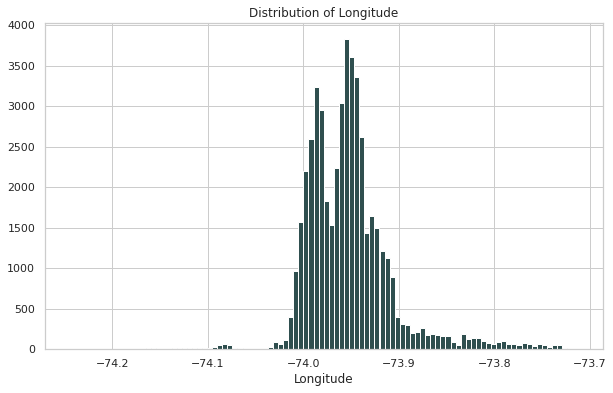

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df.longitude, color="darkslategray", bins=100)
axes.set_title("Distribution of Longitude")
axes.set_xlabel("Longitude")

plt.show()
plt.close()

The data here is also reasonably normally distributed but in a narrower band than latitude. Intuitively, this is probably because NYC is taller than it is wide, so it lines up in that sense.  There are a few peaks that most likely correspond with neighborhoods, if I plot latitude and longitude I should see something that resembles a map I think.

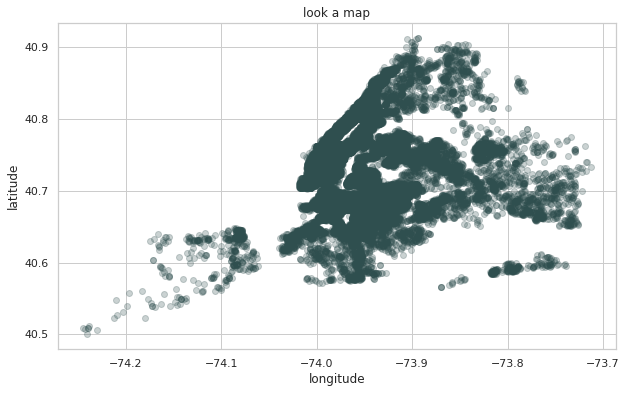

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(df.longitude, df.latitude,marker="o", color="darkslategray",alpha=.25)

axes.set_xlabel("longitude")
axes.set_ylabel("latitude")
axes.set_title("look a map")

plt.show()
plt.close()

We can see that bottom left section resembles Staten Island. And additionally we can see how the majority of the listings are in the center, with the dark entirely filled Manhattan area. The sliver of white in that area is probably central park!


## Minimum nights

Here we will perform EDA on the `minimum_nights` variable.

`minimum_nights` is the the minimum number of nights that a tenant would have to stay at the property. Let's look at some summary statistics for `minimum_nights` to get a sense for the range that is actually covered in the data, and whether there are any anomalies (like a minimum stay of several months... that would probably be closer to a lease!).

In [ ]:
df.minimum_nights.describe()

count    48884.000000
mean         7.029887
std         20.512224
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

The minimum `minimum_nights` is 1 day, which makes sense. You have to stay 1 day at the property, at the very least. What is peculiar is the 1250 night maximum value that we see -- that's nearly 3 and a half years.

In terms of distribution, a full quarter of the listings have a minimum stay of just 1 day. Half of the listings are between 1 day and 3 days. 75% of the listings require you to stay at least 5 days. 

The average number of minimum stays is around 7 days, which, due to how many of the listings have just 1 day, we expect to be distorted, as the mean is sensitive to outliers. The standard deviation is 20 days, which is a figure that is also sensitive to outliers.

Let's plot the distribution of `minimum_nights` so that we can get a sense of what the distribution looks like:

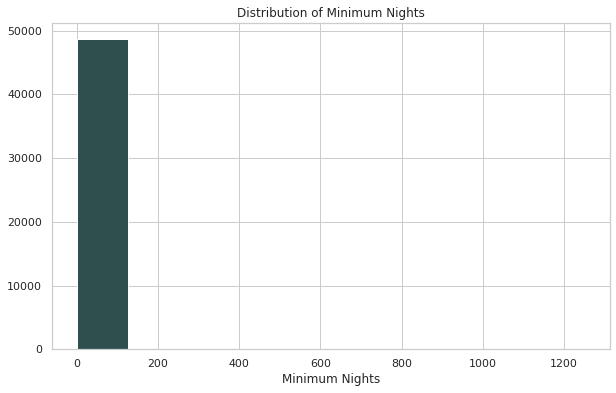

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df.minimum_nights, color="darkslategray")
axes.set_title("Distribution of Minimum Nights")
axes.set_xlabel("Minimum Nights")

plt.show()
plt.close()

We can't get a good gauge of what the distribution looks like at all –– the listing(s?) of 1250 minimum nights is throwing off our plot. Let's look into just exactly how many listings are this odd.

 Let's look into just 30 days as the cutoff point:

In [ ]:
df[df.minimum_nights > 30].minimum_nights.count()

747

In [ ]:
df[df.minimum_nights <30].minimum_nights.describe()

count    44379.000000
mean         3.511345
std          4.267486
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         29.000000
Name: minimum_nights, dtype: float64

It appears that there are only 747 entries that are over 30 days, out of a total of 48895 entries. In other words, a little over 1.5% of the entries are over 30 days, which seems to make enough sense. [Research](https://www.airdna.co/blog/whats-the-best-minimum-night-stay-policy-on-airbnb) from an AirBnB-adjacent company called AirDNA seems to confirm that one rarely gets listings over 30 days.

Further, if we look at some summary statistics again without the offending entries, the mean looks much more different, and the standard deviation looks a lot more reasonable as well. We know that this variable is quite sensitive to outliers, and we will need to decide what to do with it when performing regression re: unreasonably large numbers of minimum nights. 

Before we dig into what makes these listings have such a high number of minimum nights, we should finish up looking at the distribution, but this is an important thing to keep in mind for later. 

Let's try looking at the distribution again, but this time stipulate that the scale for our x-axis be not over 30 days. 

We should expect that there are a many listings where the minimum nights is only 1 –– it makes sense that property owners would want to reduce the barrier to entry as much as possible to get as many clients as possible.

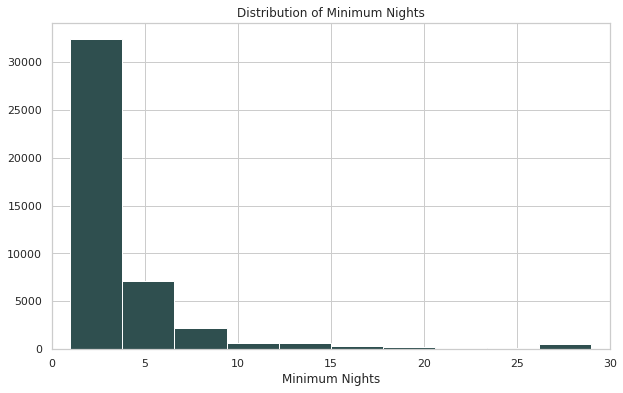

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df.minimum_nights[df.minimum_nights < 30], color="darkslategray")
axes.set_title("Distribution of Minimum Nights")
axes.set_xlabel("Minimum Nights")
axes.set_xlim(left = 0, right=30)

plt.show()
plt.close()

Expectedly, we see the vast majority of listings be at around 1. The number of minimum nights rapidly decreases past 1. Let's use Freeman-Diaconis bins to see some higher fidelity; is it all 1s, or is it some 1s and some 2s?

In [ ]:
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    # if the number is so small that it goes to 0, don't just return 0, return 1.
    if int(h) == 0:
        return 1
    return int( h)

Freeman Diaconis Bins: 	 1


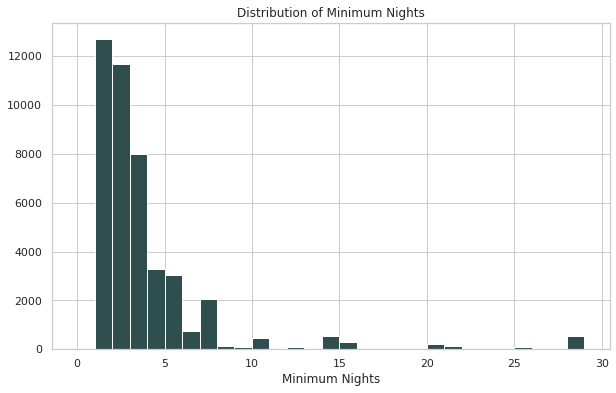

In [ ]:
h = freeman_diaconis(df[df.minimum_nights < 30].minimum_nights)
print(f"Freeman Diaconis Bins: \t {h}")
mn = 0
mx = 30
bins = [i for i in range(mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df.minimum_nights[df.minimum_nights < 30], color="darkslategray", bins = bins)
axes.set_title("Distribution of Minimum Nights")
axes.set_xlabel("Minimum Nights")


plt.show()
plt.close()


Interestingly enough, we have almost as many 2 night minimum stays as there are 1 night minimum stays! The vast majority of the minimum stays appear to be clustered between the 1 to 5 night portion. There are also a few bumps that we see pop up at around 5 day intervals, like 10, 15, 20, 25.

We can also see that there is a bump at around 7 days, 14 days, 21 days, 28 days. Since people like to section of times when talking about date ranges, it's no surprise that weeks is a sort of "standard measurement" once we get past just talking about a couple of days. 

OK, we've definitely gotten somewhere. It looks like we've confirmed that there are a relatively low number of listings that have an absurd amount of minimum nights (1000 minimum nights?). Let's try to correct for that and zoom in closer, as we did previously with the histograms.

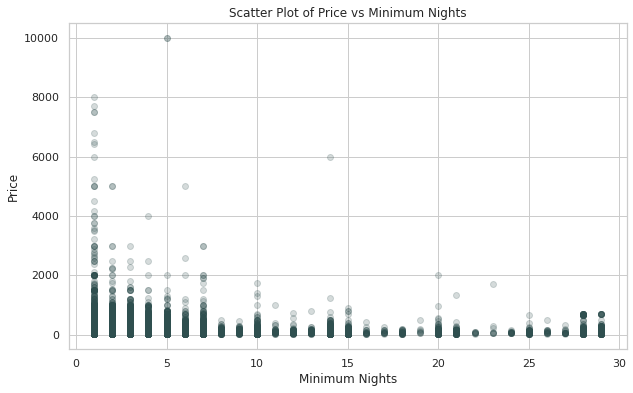

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( df[df.minimum_nights < 30].minimum_nights, df[df.minimum_nights < 30].price, marker="o", color="darkslategray", alpha = 0.2)

axes.set_ylabel("Price")
axes.set_xlabel("Minimum Nights")
axes.set_title("Scatter Plot of Price vs Minimum Nights")

plt.show()
plt.close()

We definitely see some of what we conjectured earlier –– those who want to list their listings at a higher price generally would choose to have their minimum nights be at 1. As the minimum nights increase, it appears that listings with higher and higher ends of prices are less common. 

In other words, a low number of minimum nights isn't a "sufficient condition" to whether or not a listing will have a high price, but it could be a "necessary" one. Of course, both of these terms are used quite loosely –– all this is to say that if it is the case that a listing has a high price, it's probable that it will have a lower number of minimum nights. 

## Number of Reviews

`number_of_reviews` is the number of reviews left by previous tenatns of an AirBnB listing. A person has stayed at the place, and has left some comments about it. Let's look at some summary statistics to get a sense of what the range looks like. 

In [ ]:
df.number_of_reviews.describe()

count    48884.000000
mean        23.271991
std         44.551331
min          0.000000
25%          1.000000
50%          5.000000
75%         24.000000
max        629.000000
Name: number_of_reviews, dtype: float64

It looks like 25% of listings have between 0 reviews and 1 review. Half of the listings have 5 reviews or fewer. 75% of the lsitings have 24 reviews or fewer. The maximum number of reviews on a single listing is 629!

Let's plot this in order to get a good lok at how this variable is distributed. 

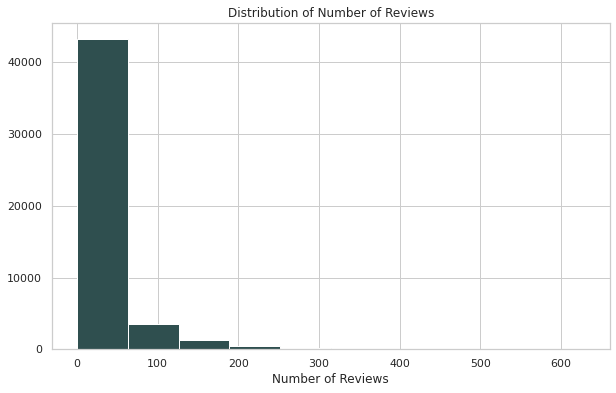

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df.number_of_reviews, color="darkslategray")
axes.set_title("Distribution of Number of Reviews")
axes.set_xlabel("Number of Reviews")

plt.show()
plt.close()

It appears that listings with reviews higher than around 250 are extremely rare -- the vast majority of listings have fewer than that number of reviews. From the previous summary statistics, as well as this distribution, we can reliably conclude that listings with over 250 reviews can be considered outliers (but not removed). It is clear that, generally, most listings have only a handful of reviews. Listings with higher numbers of reviews are much more rare comparatively. 

Let's try limiting our scope to only listings below this number, while keeping in mind that these value are still there.

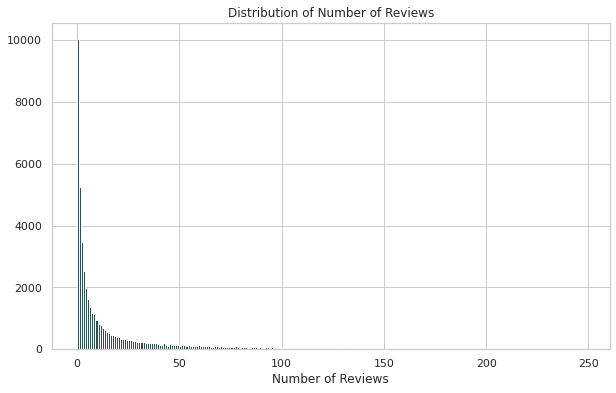

In [ ]:
h = freeman_diaconis(df[df.number_of_reviews < 250].number_of_reviews)
mn = df[df.number_of_reviews < 250].number_of_reviews.min()
mx = df[df.number_of_reviews < 250].number_of_reviews.max()
bins = [i for i in range(mn,mx,h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df[df.number_of_reviews < 250].number_of_reviews, color="darkslategray", bins = bins)
axes.set_title("Distribution of Number of Reviews")
axes.set_xlabel("Number of Reviews")

plt.show()
plt.close()

It appears that the distribution resembles an exponential distribution as we zoom in closer, or perhaps a Poisson distribution with an extremely low $\lambda$. This could make some sense, with the caveats that reviews over time are not independent of each other, that listings were not all put up at the same time, and so on. 

The vast majority of listings appear to have no reviews at all. We can try and confirm this:

In [ ]:
df.number_of_reviews.value_counts()

0      10051
1       5243
2       3464
3       2519
4       1994
       ...  
404        1
436        1
388        1
341        1
607        1
Name: number_of_reviews, Length: 394, dtype: int64

Over a fifth of these listings have no reviews at all. Around half of that number have only one review. The numbers don't quite halve at every step of the review, but it's close. 

## Room Type

Based off the head, and my interactions with AirBnB, I believe that there should be two options:
* Private room
* Entire home/apt
    
In regards to distribution, I believe there should be approximately an even distribution between the room types.

Will be looking to confirm:  
1)	Room types within dataset  
2)	Distribution between room types

In [ ]:
#Summarize catergory method

def summarize_category(series):
    res_regu = value_counts(series)
    res_norm = value_counts(series, normalize=True)
    result = concat([res_regu, res_norm], axis=1, keys=['Count', 'Frequency'])
    result = result.sort_index()
    return result


In [ ]:
summarize_category(df["room_type"])

,Count,Frequency
Entire home/apt,25407,0.519741
Private room,22319,0.456571
Shared room,1158,0.023689


There are three room types within the dataset:  

1) Entire home/apt  
2) Private room
3) Shared room  

Only 2% of the observations are a shared room, while entire home/apt and private room are in higher quantities, at 52% and 46% respectively.

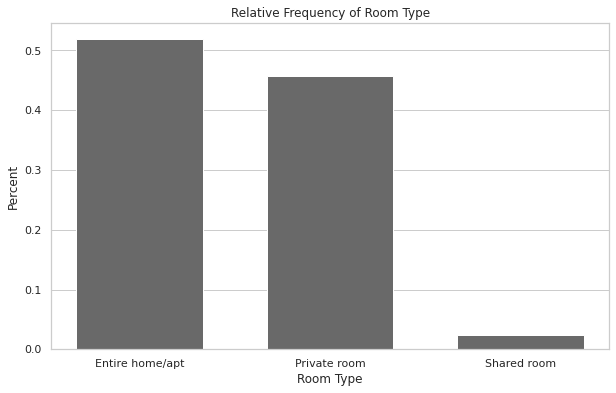

In [ ]:
counts = df["room_type"].value_counts().sort_index()
proportions = df["room_type"].value_counts(normalize=True).sort_index()

x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, proportions, width, color="dimgray", align="center")
axes.set_xlabel("Room Type")
axes.set_xticks(x)
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Relative Frequency of Room Type")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)
plt.setp( axes.xaxis.get_majorticklabels(), rotation=0)
plt.show()
plt.close()

The figure above, visually represents the distribution between room types.

# 2b) Pairwise EDA

### Price vs. Number of Reviews

Here we're going to look at number of reviews. The idea is that, if a listing has a higher number of reviews, they can command a higher price on the market given that they're "trusted". In other words, we're expecting that, as number of reviews goes up, so too does the price. Let's first look at some correlation coefficients to see whether this is the case. 

In [ ]:
print("r   = ", stats.pearsonr( df.price, df.number_of_reviews)[0])
print("rho = ", stats.spearmanr( df.price, df.number_of_reviews)[0])

r   =  -0.04792566604580445
rho =  -0.05489794181622098


There is almost no relationship between these two variables. It seems like we were mistaken. Let's plot these variables to see whether there is some underlying structure that we had missed regarding the relationship between these variables. 

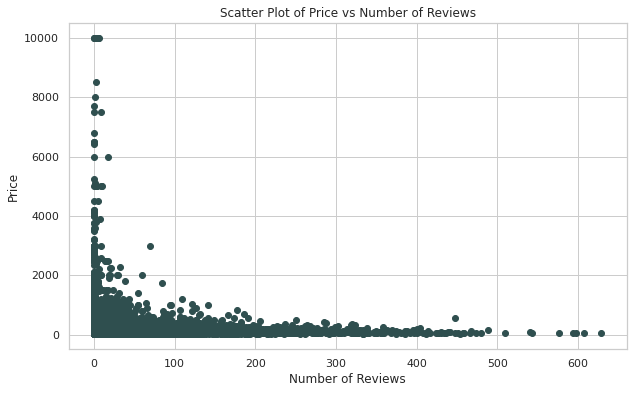

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( df.number_of_reviews, df.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Number of Reviews")
axes.set_title("Scatter Plot of Price vs Number of Reviews")

plt.show()
plt.close()

It appears that most of the more expensive listings are all clustered at around 0 reviews or 1 reviews. Could it be the case that the extremely expensive listings are just not being rented out to anybody at all?  Are these listings on the rare side, or are they more of the common listings? Prices are set by the owner of the AirBnB themselves, so it could definitely be the case that they're set just willy-nilly, and nobody at all is going to look at them! 

There does, however, seem to be some overplotting happeniing here. Just like last time, let's try to add some transparency to correct for this. 

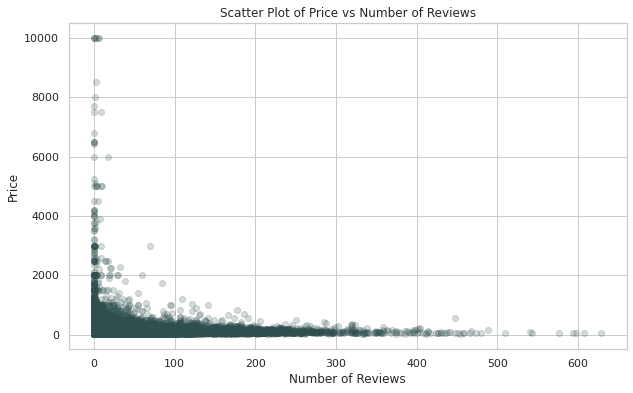

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( df.number_of_reviews, df.price, marker="o", color="darkslategray", alpha =0.2)

axes.set_ylabel("Price")
axes.set_xlabel("Number of Reviews")
axes.set_title("Scatter Plot of Price vs Number of Reviews")

plt.show()
plt.close()

We can see that there is a dark, nearly triangular shape appearing at the bottom left of the graph. What this indicates is that, yes, these "extremely high priced, no review" listings are on the rarer side of things. However, it appears that, the higher the numnber of your reviews go, the smaller and smaller your price becomes!

This is actually rather telling. It could definitely be the case that the most amount of people would go for an AirBnB listing that's on the cheaper side –– the more number of reviews a place has, it actually probably means that it was cheap enough to the point where hundreds of people were able to comfortably afford it! 

In other words, the number of reviews isn't really a measure of how successful or trusted a listing is. It could very well be the case that, the higher your reviews, the more likely it is that you just have a cheaper place that more people want to stay at. 

### Price vs. Minimum Nights

With price being our target variable, we're interested in whether the minimum nights has any predictive power as to what the price is. 

Minimum nights seem it could be an explanatory variable as to the price. One would expect that, as the minimum nights goes up, the owner of the property can command lower prices as they've got a guarantee that they can make a certain amount of money from a tenant. Conversely, listings with minimum nights at 1 or 2 days would probably be more comfortable putting their prices higher –– if they only require the tenant to stay there for a few days, it is at least somewhat reasonable that the price be higher. 

Let's first look at some correlation coefficients. I would expect this relationship to negative monotonic, but not necessarily linear. We're going to look at Pearson's $r$ and Speearman's $\rho$.

In [ ]:
print("r   = ", stats.pearsonr( df.price, df.minimum_nights)[0])
print("rho = ", stats.spearmanr( df.price, df.minimum_nights)[0])

r   =  0.04280493106996231
rho =  0.10132962294422189


Unfortunately, we see a very weak, almost nonexistent relationship from both the Pearson's correlation coefficient, as well as Spearman's $\rho$. 

Perhaps there is an underlying structure that we do not see from just correlation coefficients. Let us plot this data to see if there is anything we can ascertain. 



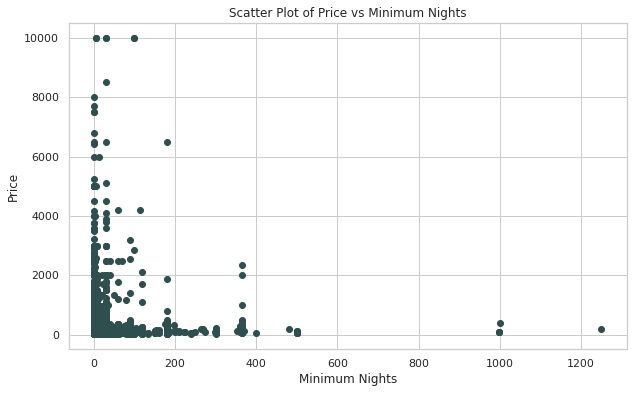

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( df.minimum_nights, df.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Minimum Nights")
axes.set_title("Scatter Plot of Price vs Minimum Nights")

plt.show()
plt.close()

A few things that we can note here. 
- As we previously saw, the large number of minimum nights is preventing us from seeing finer detail in the smaller minimum nightts portion of the graph. 
- There may be some issues with overplotting

Let's try to correct for these things one at a time. First, let's lower the transparerncy for the dots on the graph a bit to correct for overplotting. We want to see where there arer strong clusters that may outline a relationship, and we want to see whether certain points may just be odd outliers.

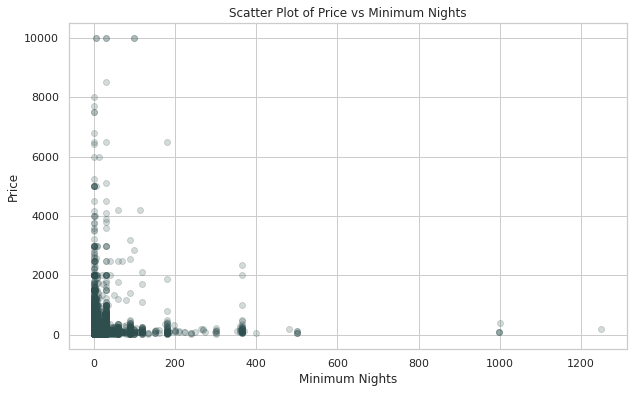

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( df.minimum_nights, df.price, marker="o", color="darkslategray", alpha = 0.2)

axes.set_ylabel("Price")
axes.set_xlabel("Minimum Nights")
axes.set_title("Scatter Plot of Price vs Minimum Nights")

plt.show()
plt.close()

### Price vs. Latitude and Longitude

Now for the question at hand, can the latitude and longitude be predictors of price? The problem with this is that it cannot be a simple numerical comparison as its unlikely that latitude and longitude would have a monotonic relationship with price since it depends on the neighborhood. I'll plot the latitude/longitude v price and list the pearson/spearman correlations.

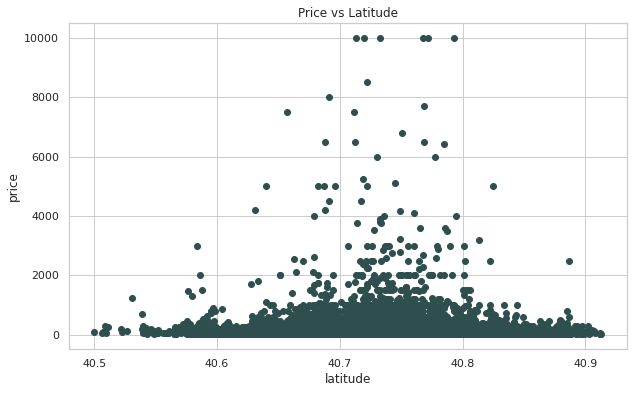

Correlation coefficients:
r = 0.03389864519164617
rho = 0.13604570786554945


In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1) 
axes.scatter(df.latitude, df.price,marker="o", color="darkslategray")

axes.set_xlabel("latitude")
axes.set_ylabel("price")
axes.set_title("Price vs Latitude")

plt.show()
plt.close()

correlation(df,'latitude','price')

As expected, the correlation is very low since it's not a simple linear relationship. However we can see that the greatest values are in the middle of the latitude. What might make the most sense if we really want to use latitude would be to turn the values into categories, defining regions that may be more indicative of price.

I'll check longitude for the same.

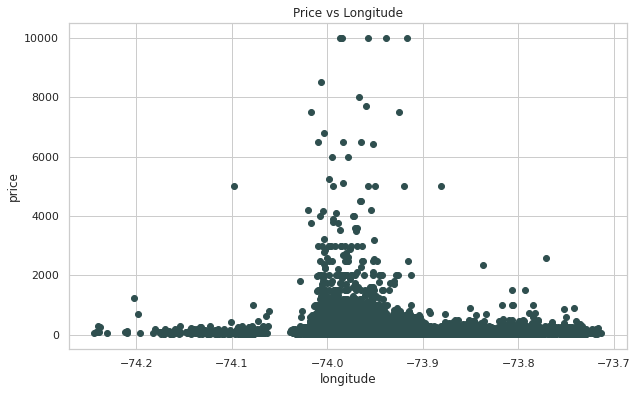

Correlation coefficients:
r = -0.149954295866094
rho = -0.4378899097474148


In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(df.longitude, df.price,marker="o", color="darkslategray")

axes.set_xlabel("longitude")
axes.set_ylabel("price")
axes.set_title("Price vs Longitude")

plt.show()
plt.close()

correlation(df,'longitude','price')

Same problem here as with latitude. There isn't a linear or polynomial correlation of longitude with price, but we can definitely see that longitudes in the -74 to -73.9 range seem to have higher prices, while the edges are generally lower. We could setup grid regions if we wanted to and turn latitude/longitude into a categorical variable as part of the model, but if we already have neighborhoods we could possibly do without this variable.

We'll calculate a distance variable from the point (40.75, -73.98) which, when looking at [Google Maps](https://www.google.com/maps/place/40%C2%B045'00.0%22N+73%C2%B058'48.0%22W/@40.7473781,-74.0000738,12.96z/data=!4m5!3m4!1s0x0:0x0!8m2!3d40.75!4d-73.98), is just a couple blocks away from the Empire State Building and Central Park in Midtown.

In [ ]:
df["dist_from_mid"] = ((40.75 - df["latitude"])**2 +(-73.98 - df["longitude"])**2)**(.5)
df["dist_from_mid"].describe()

count    48884.000000
mean         0.066112
std          0.044166
min          0.000481
25%          0.032962
50%          0.061341
75%          0.084727
max          0.361445
Name: dist_from_mid, dtype: float64

The count is 48895 records, so that is correct, this should be the distance away from the midtown point I specified. The maximum value is .36 which is an order of magnitude from the 75% quartile, this is likely an outlier. I'll do a histogram on this to get a look at the number of listings as distance changes. The majority should be near 0, decreasing as the distance increases.

Text(0.5, 1.0, 'Distribution of Distance')

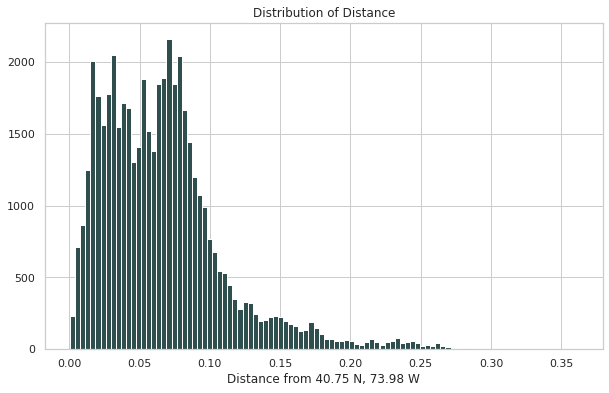

In [ ]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1,1,1)
axes.hist(df["dist_from_mid"], color='darkslategray',bins = 100)
axes.set_xlabel('Distance from 40.75 N, 73.98 W')
axes.set_title('Distribution of Distance')

As expected we get most of the data to the left, but there are some local peaks in the data that look similar to what I saw in the EDA for the latitude and longitude separately.

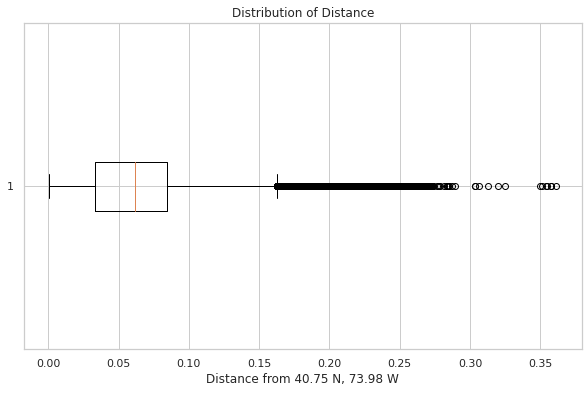

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.boxplot(df["dist_from_mid"], vert=False)
axes.set_title("Distribution of Distance")
axes.set_xlabel("Distance from 40.75 N, 73.98 W")

plt.show()
plt.close()

The problem with this is that while the majority of the data (>75%) is less than .02 there is a significant amount of data that is greater and makes outliers a bit more difficult to identify. From the box plot it seems like we could remove data >0.3 and not lose too much but that would really just to improve the look of the histogram, which might not be necessary. We'll do the comparison scatterplot to Price to see if there are correlations we can see.

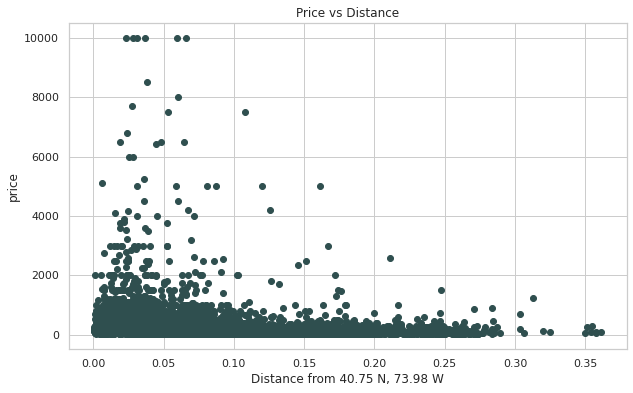

Correlation coefficients:
r = -0.1693819003129165
rho = -0.4799302895812406


In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(df["dist_from_mid"], df["price"],marker="o", color="darkslategray")

axes.set_xlabel("Distance from 40.75 N, 73.98 W")
axes.set_ylabel("price")
axes.set_title("Price vs Distance")

plt.show()
plt.close()

correlation(df,'dist_from_mid','price')

None of the correlations get over the .5 mark to be a strong correlation so it seems like this won't be a strong indicator for Price. Visually, there looks like a little bit of a relation (all the expensive ones are in midtown) but there is far too much data at lower prices that matches with the other areas to have a strong correlation.

### Price vs. Reviews Per Month 


In order to compare the relationship between reviews per month and price, we first need to remove the missing values from the reviews per month column. Let's first define some functions we need to use:

In [ ]:
def correlation(data, x, y):
    print("Correlation coefficients:")
    print( "r =", stats.pearsonr(data[x], data[y])[0])
    print( "rho =", stats.spearmanr(data[x], data[y])[0])

The below dataframe excludes all the missing values from the data, leaving us with 38,821 observations:

In [ ]:
df_no_missing = df.dropna()
df_no_missing.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Studio,1BR,2BR,3BR,4BR,Room,RevStudio,Rev1BR,Rev2BR,Rev3BR,Rev4BR,RevRoom,host_experience,host_experience_average,host_experience_high,host_experience_low,log_price
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,0,0,0,0,0,0,0,0,0,0,0,0,average,1,0,0,2.173186
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,0,0,0,0,0,0,0,0,0,0,0,0,average,1,0,0,2.352183
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,0,0,0,0,0,0,0,0,0,0,0,0,low,0,0,1,1.949390
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,1,0,0,0,0,0,1,0,0,0,0,0,low,0,0,1,1.903090
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,0,1,0,0,0,0,0,1,0,0,0,0,low,0,0,1,2.301030


We expect that the number of reviews per month might affect the price in a positive way. Let's take a look at the correlation between these two variables:

In [ ]:
correlation(df_no_missing, "reviews_per_month", "price")

Correlation coefficients:
r = -0.03058924921875942
rho = -0.01861871607688525


With Pearson's and Spearman's coefficients lower than 0.5, it seems that there is not a strong linear or monotonic relationship between price and reviews per month. Surprisingly, the sign of the correlation is negative which was not expected.

In [ ]:
import statsmodels.api as sm
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):
    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]
        
    figure = plt.figure(figsize=(10, 6))
    
    axes = figure.add_subplot(1, 1, 1)
    
    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)
        
    axes.scatter(xs, data[y], marker="o", color="darkslategray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")
    
    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)
    plt.show()
    plt.close()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


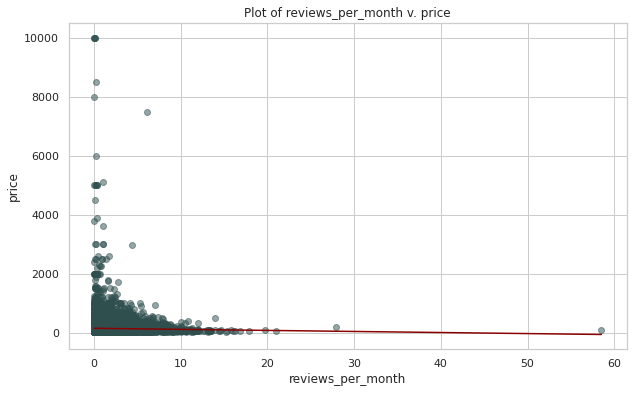

In [ ]:
lowess_scatter(df_no_missing, "reviews_per_month", "price", jitter=0.0, skip_lowess=True)

As shown in the scatter plot, there is no strong relationship between reviews_per_month and the target variable, price. 

### Price vs. Neighborhood_group
As we have just seen, the price data has an irregular distribution. As we saw before with the insurance charges data, such distributions can result from a mixture of processes that are creating distinct subgroups or populations in the data. The $1m question is whether we can identify those subgroups using the data we have:

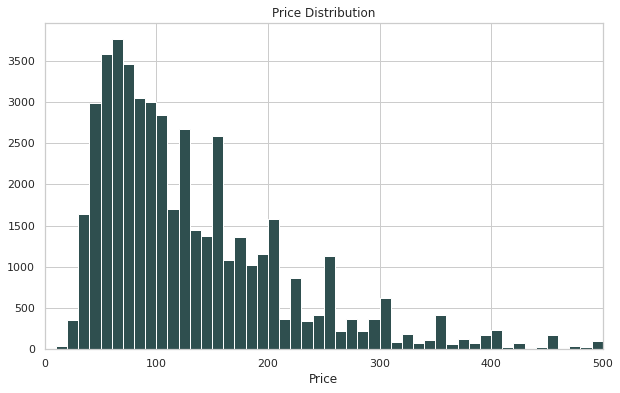

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df.price,bins=1000,  color = "darkslategray")
axes.set_title("Price Distribution")
axes.set_xlabel("Price")
axes.set_xlim((0,500))

plt.show()
plt.close()

In [ ]:
describe_by_category(df, "price", "neighbourhood_group", transpose=True)

neighbourhood_group,Bronx,Brooklyn,Manhattan,Queens,Staten Island
count,1090.000000,20095.000000,21660.000000,5666.000000,373.000000
mean,87.577064,124.438915,196.884903,99.517649,114.812332
std,106.725371,186.896837,291.386838,167.102155,277.620403
min,10.000000,10.000000,10.000000,10.000000,13.000000
25%,45.000000,60.000000,95.000000,50.000000,50.000000
50%,65.000000,90.000000,150.000000,75.000000,75.000000
75%,99.000000,150.000000,220.000000,110.000000,110.000000
max,2500.000000,10000.000000,10000.000000,10000.000000,5000.000000


Manhattan clearly has a mean close to 200 (against the closest competitor - Brooklyn at 124), but the same max of 10,000 just like Brooklyn and Queens. At 291, Manhattan also has the highest standard deviation (volatility) of price.   

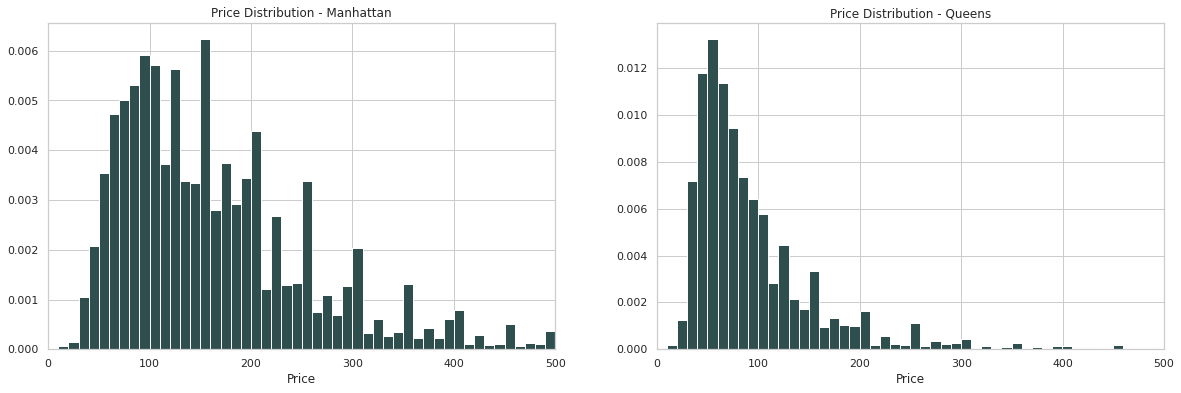

In [ ]:
grouped = df.groupby("neighbourhood_group")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["price"].get_group("Manhattan"), color = "darkslategray", bins = 1000, density=True)
axes.set_title("Price Distribution - Manhattan")
axes.set_xlabel("Price")
axes.set_xlim((0,500))

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["price"].get_group("Queens"), color = "darkslategray", bins = 1000, density=True)
axes.set_title("Price Distribution - Queens")
axes.set_xlabel("Price")
axes.set_xlim((0,500))

plt.show()
plt.close()

Plotting the price distribution for Manhattan against that of Queens (4 to 1 listisngs ratio) reveals striking differences in distribution. Will be looking into this during the regression stage.

### Price vs availability_365

Lets see how price relates to availability_365.

In [ ]:
print("r   = ", stats.pearsonr( df.price, df.availability_365)[0])
print("rho = ", stats.spearmanr( df.price, df.availability_365)[0])

r   =  0.08184749749030194
rho =  0.08617478213384956


As expected, there is no strong positive relationship between the price and availability_365. Lets look at the plots.

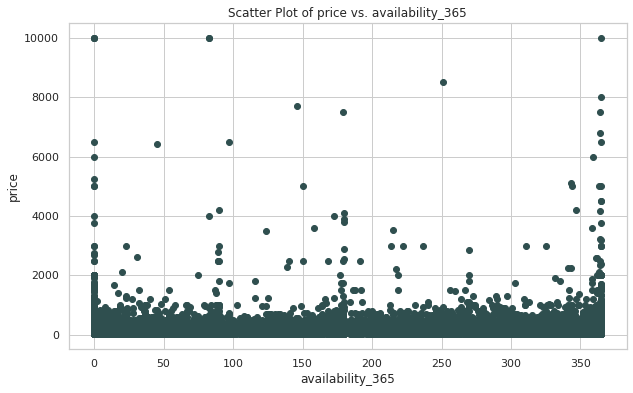

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(df.availability_365, df.price,marker="o", color="darkslategray")

axes.set_xlabel("availability_365")
axes.set_ylabel("price")
axes.set_title("Scatter Plot of price vs. availability_365")

plt.show()
plt.close()

### Price vs Calculated_host_listings_count

Here, we are going to perform pairwise EDA on `calculated_host_listings_count` and `price. 

Lets see how the calculated_host_listings_count relates to price by looking at some correlation coefficients. We can look at the relationship between `price` and `calculated_host_listings_count` as well as the transformed variable `host_experience`.

In [ ]:
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        return(grouped_y.transpose())
    else:
        return(grouped_y)

In [ ]:
print("r   = ", stats.pearsonr( df.price, df.calculated_host_listings_count)[0])
print("rho = ", stats.spearmanr( df.price, df.calculated_host_listings_count)[0])

r   =  0.057461906077439354
rho =  -0.10571457994940378


The $r$ coefficient is not significant, and neither is the Spearman's $\rho$ coefficient. What this indicates is that there is likely no correlation between `price` and `calculated_host_listings`, and that there is no relationship of monotonicity.

Let's plot a scatter plot to see if there are any underlying structures of association that can be revealed through visualization.

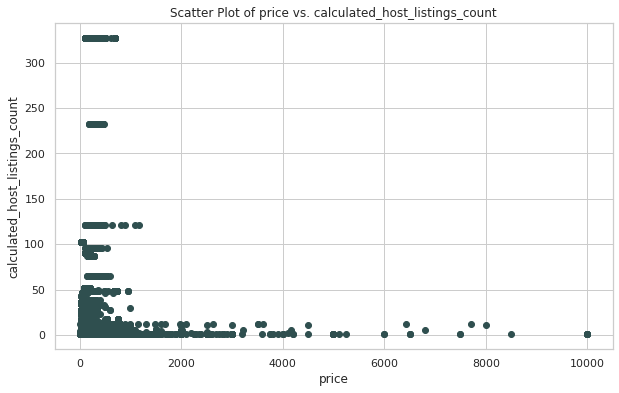

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( df.price, df.calculated_host_listings_count, marker="o", color="darkslategray")

axes.set_xlabel("price")
axes.set_ylabel("calculated_host_listings_count")
axes.set_title("Scatter Plot of price vs. calculated_host_listings_count")

plt.show()
plt.close()

There does not seem to be any significant relationship between these two variables. Let's see if we can gain some insight from the transformed variable, `host_experience`. We should first look at some descriptive statistics for each category that we have binned these variables into. 

In [ ]:
describe_by_category(df, "price", "host_experience")

,count,mean,std,min,25%,50%,75%,max
host_experience,,,,,,,,
average,13616.0,124.875073,184.074273,10.0,58.0,85.0,140.0,7500.0
high,2967.0,216.115268,329.729756,18.0,99.0,175.0,244.0,8000.0
low,32301.0,158.687502,249.596295,10.0,75.0,119.0,180.0,10000.0


We can see that, for an "average" host, the mean price is actually lower relative to a more experienced host. It could be the case that a more experienced host would be able to command higher prices as they know what "sells", or it could be the case that a more "experienced" host is actually just a "richer" host with deeper pockets. In other words, it could be the case that hosts with higher property counts are able to purchase, furnish, and rent out more expensive properties and make more money in more expensive parts of town.

Let's look at a boxplot for each of the categories to get a visual for the range. It will not be much different than what we have here (and it may even obscure some of the more specific insights) but it will tell us around what sort of ranges there will likely be outliers.

In [ ]:
def multiboxplot(data, numeric, categorical, skip_data_points=True):
    figure = plt.figure(figsize=(10, 6))
    
    axes = figure.add_subplot(1, 1, 1)
    
    grouped = data.groupby([categorical])
    labels = pd.unique(data[categorical].values)
    labels.sort()
    grouped_data = [grouped[numeric].get_group(k) for k in labels]
    patch = axes.boxplot(grouped_data, labels=labels, patch_artist=True, zorder=1)
    
    if not skip_data_points:
        for i, k in enumerate(labels):
            subdata = grouped[numeric].get_group( k)
            x = np.random.normal(i + 1, 0.01, size=len(subdata))
            axes.plot(x, subdata, 'o', alpha=0.4, color="DimGray", zorder=2)
            
    axes.set_xlabel(categorical)
    axes.set_ylabel(numeric)
    axes.set_title("Distribution of {0} by {1}".format(categorical, numeric))
    
    plt.show()
    plt.close()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


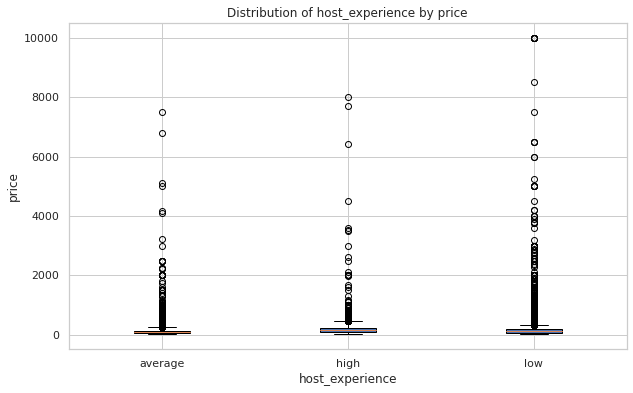

In [ ]:
multiboxplot(df, 'price', "host_experience", skip_data_points=True)

As expected, we can see that this boxplot does not give us much to work with. However, it does seem like the outliers for "average" hosts and "high" hosts fall lower than "low" hosts. 

### Price vs. room_type

One would expect that “entire apts/homes” will cost more than a “private room”. A “share room”, will be cost the least. 

In [ ]:
grouped = df.groupby( "room_type")
grouped_roomType = grouped["price"].describe()

grouped_roomType

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,25407.0,211.810918,284.046575,10.0,120.0,160.0,229.0,10000.0
Private room,22319.0,89.809131,160.222493,10.0,50.0,70.0,95.0,10000.0
Shared room,1158.0,70.248705,101.771306,10.0,33.0,45.0,75.0,1800.0


As expected, the mean for the “entire homes/apt” is the highest, at 211.79. The mean for “shared room” and “private room” are 70.12 and 89.78, respectively. 

Additionally, there is a larger distribution for “entire home/apt”, than “private room” and “share room”, as seen with the standard deviation. 


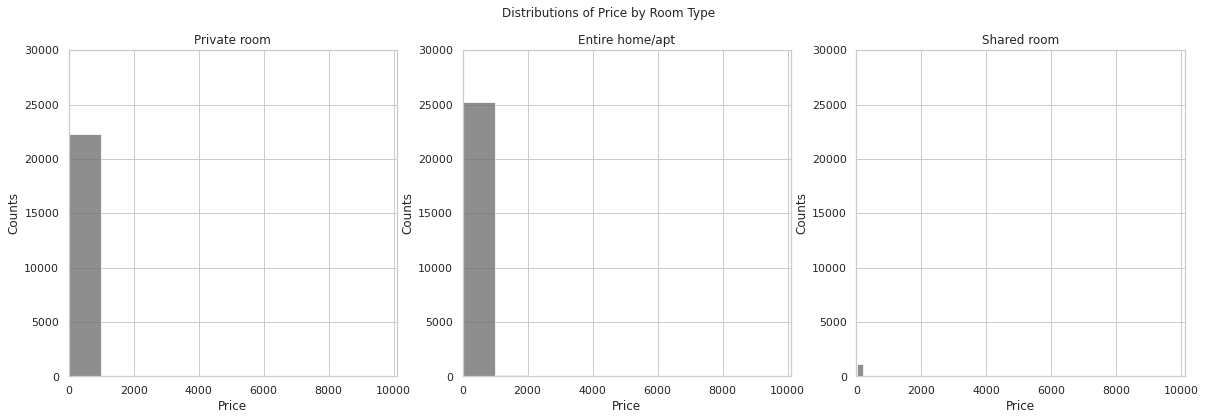

In [ ]:
figure = plt.figure(figsize=(20, 6))

figure.suptitle("Distributions of Price by Room Type")
labels = pd.unique(df["room_type"].values)

for i, x in enumerate(labels):
    axes = figure.add_subplot(1, 3, i+1)
    subdata = grouped["price"].get_group(x).values
    axes.hist(subdata, alpha=0.75, color="DimGray")
    axes.set_title(x)
    axes.set_ylim(0,30000)
    axes.set_xlim(0,10100)
    axes.set_xlabel("Price")
    axes.set_ylabel("Counts")
    
plt.show()
plt.close()

Because of the large price distribution, it is hard to get an understand of the distribution of price, using the entire scale. 

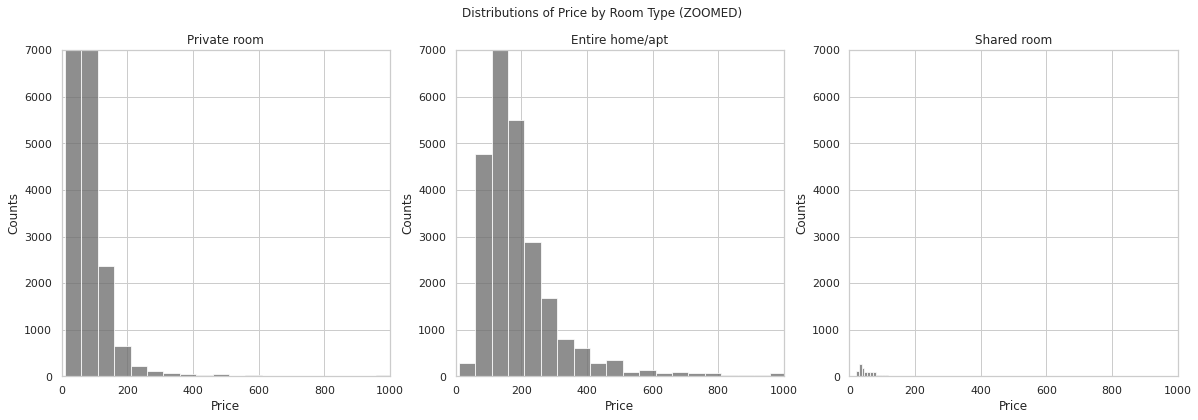

In [ ]:
figure = plt.figure(figsize=(20, 6))

figure.suptitle("Distributions of Price by Room Type (ZOOMED)")
labels = pd.unique(df["room_type"].values)

for i, x in enumerate(labels):
    axes = figure.add_subplot(1, 3, i+1)
    subdata = grouped["price"].get_group(x).values
    axes.hist(subdata, alpha=0.75, color="DimGray", bins = 200)
    axes.set_title(x)
    axes.set_ylim(0,7000)
    axes.set_xlim(0,1000)
    axes.set_xlabel("Price")
    axes.set_ylabel("Counts")
    
plt.show()
plt.close()

For the histogram above, you can see that “private room” has more values between 0-250, while “entire home/apt” has a larger distribution with more values above 250. 

Because of the scale, cannot make a comparison to “share room”.


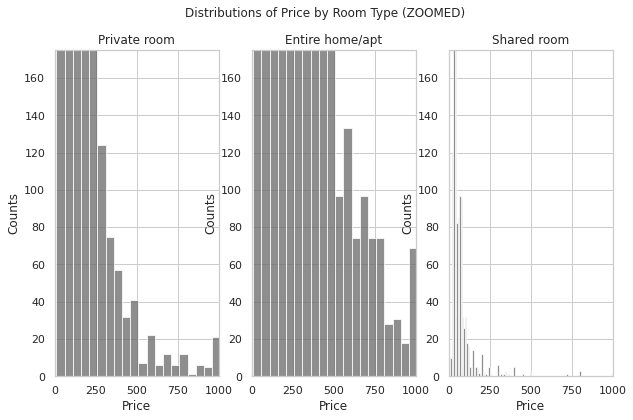

In [ ]:
figure = plt.figure(figsize=(10, 6))

figure.suptitle("Distributions of Price by Room Type (ZOOMED)")
labels = pd.unique(df["room_type"].values)

for i, x in enumerate(labels):
    axes = figure.add_subplot(1, 3, i+1)
    subdata = grouped["price"].get_group(x).values
    axes.hist(subdata, bins= 200, alpha=0.75, color="DimGray")
    axes.set_title(x)
    axes.set_ylim(0,175)
    axes.set_xlim(0,1000)
    axes.set_xlabel("Price")
    axes.set_ylabel("Counts")
    
plt.show()
plt.close()

Zoomed in scale, allows you to see that most of the values for “shared room” are low, with a narrow distribution. 

<h2>Transformation</h2>

In [ ]:
pd.DataFrame(df.room_type.value_counts(normalize=True))

,room_type
Entire home/apt,0.519741
Private room,0.456571
Shared room,0.023689


In [ ]:
df['entireHomeApt'] = df.room_type.apply(lambda x: 1 if x == 'Entire home/apt' else 0)

In [ ]:
pd.DataFrame(df['entireHomeApt'].value_counts(normalize=True))

,entireHomeApt
1,0.519741
0,0.480259


In [ ]:
df['privateRoom'] = df.room_type.apply(lambda x: 1 if x == 'Private room' else 0)

In [ ]:
pd.DataFrame(df['privateRoom'].value_counts(normalize=True))

,privateRoom
0,0.543429
1,0.456571


In [ ]:
df['sharedRoom'] = df.room_type.apply(lambda x: 1 if x == 'Shared room' else 0)

In [ ]:
pd.DataFrame(df['sharedRoom'].value_counts(normalize=True))

,sharedRoom
0,0.976311
1,0.023689


**For the regression model, only the following features should be used:**

* ‘entireHome/Apt’

* ‘privateRoom'

# 3) **Linear Regression Models**

During the EDA section, we made a number of transformations to the dataset. All transformations were made with the goal of better predicting price.

Here are all the variable transformations from EDA section:

* A new variable host_experience has been created as a categorical variable to be used instead of host_listing_counts with values: "average", "low", "high". This variable has been convereted into three dummy variables.
* The variable neighbourhood_group has been convereted into 5 dummy variables.
* A new variable distance_from_mid has been created from longitude and latitude variables.
* The variable Room_type with values: "privateRoom", "sharedRoom", "entireHome/Apt" has been convereted into three dummy variables.
* The variable log_price has been added to the dataset. Therefore, all the rows with price zero have been removed. 
* There are 10,052 missing values for variables "last_review" and "reviews_per_month". 
* Column "name" has been used to create 6 variables to categorize the number of bedrooms. 

In [ ]:
df["host_experience"] = "average"
df.loc[(df["calculated_host_listings_count"]<2),"host_experience"] = "low"
df.loc[(df["calculated_host_listings_count"]>10),"host_experience"] = "high"
df = pd.concat([df, pd.get_dummies(df["host_experience"], prefix="host_experience")], axis=1)

In [ ]:
df["log_price"] = df[ "price"].apply(lambda x: np.log10(x))

In [ ]:
df = df[df.price != 0]

In [ ]:
df["dist_from_mid"] = ((40.75 - df["latitude"])**2 +(-73.98 - df["longitude"])**2)**(.5)

In [ ]:
df = pd.concat([df, pd.get_dummies(df["neighbourhood_group"], prefix="neighbourhood_group")], axis=1)

In [ ]:
df['entireHomeApt'] = df.room_type.apply(lambda x: 1 if x == 'Entire home/apt' else 0)

In [ ]:
df['privateRoom'] = df.room_type.apply(lambda x: 1 if x == 'Private room' else 0)

In [ ]:
df['sharedRoom'] = df.room_type.apply(lambda x: 1 if x == 'Shared room' else 0)

In [ ]:
df["corrected_minimum_nights"] = df["minimum_nights"]
df.loc[(df.minimum_nights >30),"corrected_minimum_nights"]=30

In [ ]:
hooddesc = describe_by_category(df,"price","neighbourhood")
df['cheaphood'] = df.neighbourhood.apply(lambda x: 1 if hooddesc.loc[x]['mean'] < 69 else 0)
df['fancyhood'] = df.neighbourhood.apply(lambda x: 1 if hooddesc.loc[x]['mean'] > 175 else 0)

In [ ]:
df['hood'] = df.neighbourhood.apply(lambda x: hooddesc.loc[x]['mean'])
df['hood_count'] = df.neighbourhood.apply(lambda x: hooddesc.loc[x]['count'])

In [ ]:
df["corrected_reviews_per_month"] = df["reviews_per_month"]
df.loc[(df['reviews_per_month'].isna()),"corrected_reviews_per_month"] = 0

To create 6 additional variables for bedroom type, column "name" has be used to determine the value of these variables. 1 = Yes and 0 = No.

In [ ]:
df['Studio']=0
df['1BR']=0
df['2BR']=0
df['3BR']=0
df['4BR']=0
df['Room']=0

Below is the first step to categorize the number of bedroom(s).
(?i) is to ignore lower or upper case.
na=False is to ignore the 'name' column that has NaN.

In [ ]:
df.loc[(df['name'].str.contains('(?i)studio',na=False)),"Studio"] = 1
df.loc[(df['name'].str.contains('(?i)1 BR|1 BD|1 BED|1 BRD|1-BR|1-BD|1-BED|1-BDR|1BR|1BD|1BED|1BDR|one bed|one br|one bd|one bdr|one-bed|one-br|one-bd|one-bdr',na=False)),"1BR"] = 1
df.loc[(df['name'].str.contains('(?i)2 BR|2 BD|2 BED|2 BRD|2-BR|2-BD|2-BED|2-BDR|2BR|2BD|2BED|2BDR|two bed|two br|two bd|two bdr|two-bed|two-br|two-bd|two-bdr',na=False)),"2BR"] = 1
df.loc[(df['name'].str.contains('(?i)3 BR|3 BD|3 BED|3 BRD|3-BR|3-BD|3-BED|3-BDR|3BR|3BD|3BED|3BDR|three bed|three br|three bd|three bdr|three-bed|three-br|three-bd|three-bdr',na=False)),"3BR"] = 1
df.loc[(df['name'].str.contains('(?i)4 BR|4 BD|4 BED|4 BRD|4-BR|4-BD|4-BED|4-BDR|4BR|4BD|4BED|4BDR|four bed|four br|four bd|four bdr|four-bed|four-br|four-bd|four bdr',na=False)),"4BR"] = 1
df.loc[(df['name'].str.contains('(?i)room',na=False)),"Room"] = 1

Here, we create revised labels for the second step, values will be set equal to the original labels and adjustment will be made.

In [ ]:
df['RevStudio']=df['Studio']
df['Rev1BR']=df['1BR']
df['Rev2BR']=df['2BR']
df['Rev3BR']=df['3BR']
df['Rev4BR']=df['4BR']
df['RevRoom']=df['Room']

The first 4 lines of the code below is to make sure there is only one type of room for each record. It will take the minimum value because there are a lot of cases where the description is like "1 br in a 2-bedroom apt". If this is the case, 1 bedroom will be the final answer.
The fifth line of the code is to reset the value of the variable "Room". The variable "Room" is for the 'name' that contains the word "room". If the record is already categorized for the number of bedrooms, "RevRoom" will be set to zero.
The last line of the code is to move the value of "RevRoom" to "Rev1BR". The final variables to use are RevStudio, Rev1BR, Rev2BR, Rev3BR and Rev4BR.


In [ ]:
df['Rev4BR'].loc[(df['4BR']==1) & ((df['3BR']==1) |(df['2BR']==1)|(df['1BR']==1)|(df['Studio']==1))]=0
df['Rev3BR'].loc[(df['3BR']==1) & ((df['2BR']==1)|(df['1BR']==1)|(df['Studio']==1))]=0
df['Rev2BR'].loc[(df['2BR']==1) & ((df['1BR']==1)|(df['Studio']==1))]=0
df['Rev1BR'].loc[(df['1BR']==1) & (df['Studio']==1)]=0
df['RevRoom'].loc[(df['Room']==1) & ((df['Rev4BR']==1)|(df['Rev3BR']==1) |(df['Rev2BR']==1)|(df['Rev1BR']==1)|(df['RevStudio']==1))]=0
df['Rev1BR'].loc[(df['RevRoom']==1)]=1

The objective is to predict Airbnb's stay price from the available variables such as the neighbourhood, type of the room, host reviews etc.

Let's take a look at the correlation between the target variable and all the independent variables excluding reviews_per_month with missing values. 

In [ ]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [ ]:
correlations(df, "price", ["minimum_nights", "number_of_reviews", "availability_365", "neighbourhood_group_Bronx", "neighbourhood_group_Brooklyn", "neighbourhood_group_Manhattan", "neighbourhood_group_Queens", "neighbourhood_group_Staten Island", "dist_from_mid", "entireHomeApt", "privateRoom", "sharedRoom"])

,feature,r,rho
0,minimum_nights,0.042805,0.101330
1,number_of_reviews,-0.047926,-0.054898
2,availability_365,0.081847,0.086175
3,neighbourhood_group_Bronx,-0.040984,-0.109570
4,neighbourhood_group_Brooklyn,-0.098503,-0.197252
5,neighbourhood_group_Manhattan,0.163897,0.362154
6,neighbourhood_group_Queens,-0.080262,-0.195438
7,neighbourhood_group_Staten Island,-0.013853,-0.047187
8,dist_from_mid,-0.169382,-0.479930
9,entireHomeApt,0.255802,0.674630


It seems that there is no strong linear or monotonic relationship between the independent variables and the target variable, price. 

Let's first look at the null model:

In [ ]:
df["price"].describe()

count    48884.000000
mean       152.755053
std        240.170260
min         10.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

We can think of this mean price as our null model where the error is 240.17.

Now, let's try the "all in" model where we include all the variables in the model except for the variable review_per_month with missing values:

In [ ]:
model = "price ~ minimum_nights + number_of_reviews + availability_365 + neighbourhood_group_Bronx + neighbourhood_group_Brooklyn + neighbourhood_group_Manhattan + neighbourhood_group_Queens + dist_from_mid + entireHomeApt + privateRoom"
result1 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,104.58,80.56,147.89
minimum_nights,$\beta_{1}$,-0.07,-0.30,0.15
number_of_reviews,$\beta_{2}$,-0.30,-0.34,-0.27
availability_365,$\beta_{3}$,0.19,0.17,0.22
neighbourhood_group_Bronx,$\beta_{4}$,-34.77,-73.69,-14.89
neighbourhood_group_Brooklyn,$\beta_{5}$,-34.30,-77.35,-12.00
neighbourhood_group_Manhattan,$\beta_{6}$,1.18,-44.81,24.13
neighbourhood_group_Queens,$\beta_{7}$,-34.87,-74.93,-14.44
dist_from_mid,$\beta_{8}$,-533.71,-590.76,-466.27


In [ ]:
print(models.adjusted_r_squared(result1))

0.0975314311627613


The correlation coefficient is about 10% which is pretty low. The error has been reduced to 228.12 compared to the Null model error of 240.17. As we saw in the EDA section, the price does not look completely normal. Some transformations might help. About the coefficients:

* The intercept isn't particularly interesting because there are no listing with zero minimum nights, zero availability. 
* `minimum_nights` is negative and has mixed support by the data. 
* `number_of_reviews` is negative and is strongly supported by the data.
* `availability_365` is positive and is strongly supported by the data.
* `neighbourhood_group_Bronx`, `neighbourhood_group_Brooklyn`, `neighbourhood_group_Queens` are negative and are strongly supported by the data. 
* `neighbourhood_group_Manhattan` is positive and has mixed support in the data.
* `Dist_from_mid` is negative and is strongly supported by the data.
* `entireHomeApt` and `privateRoom` are both positive and are strongly supported by the data.

Let's look at the residuals of the non-categorical variables:

In [ ]:
def plot_residuals(result, variables, data):
    figure = plt.figure(figsize=(20,6))

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(data[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

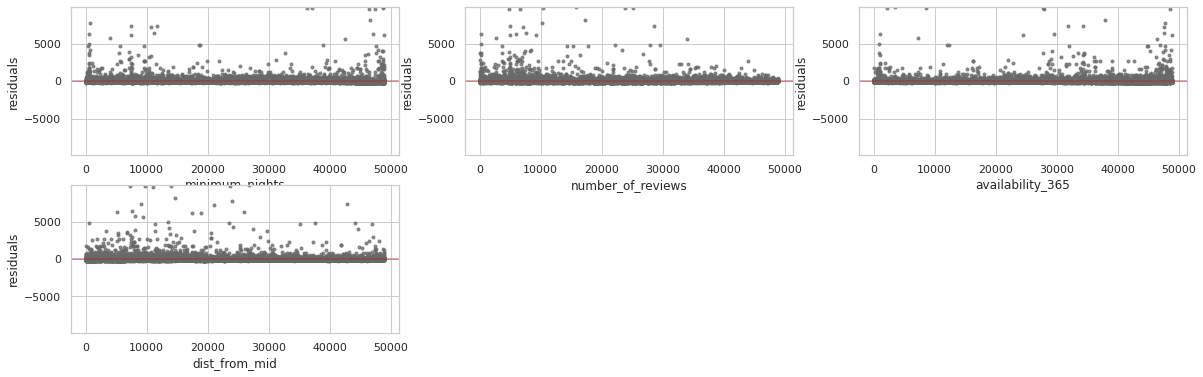

In [ ]:
residuals1 = plot_residuals(result1, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df)

The residuals seem to indicate that we are predicting far above the actual values in many cases.

Since the price distribution was not completely normal, a transformation might help to improve the model:

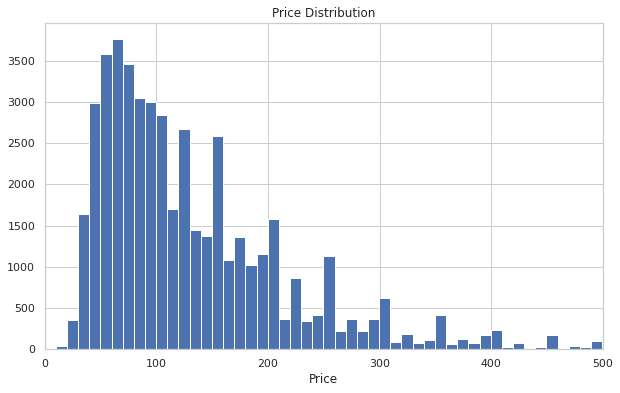

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df.price,bins=1000)
axes.set_title("Price Distribution")
axes.set_xlabel("Price")
axes.set_xlim((0,500))

plt.show()
plt.close()

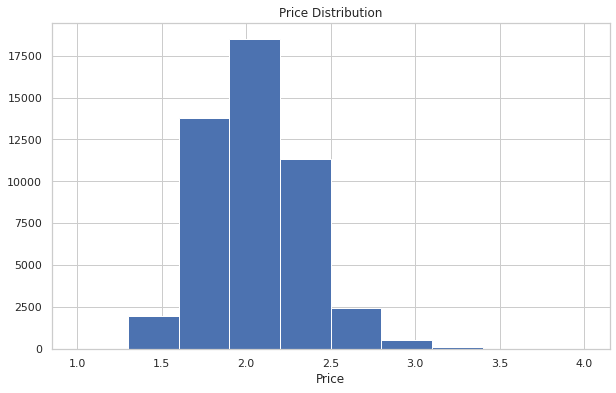

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(df.log_price)
axes.set_title("Price Distribution")
axes.set_xlabel("Price")

plt.show()
plt.close()

The distribution has been significantly improved and looks much normal. We creat the full-model again but using the new transformed target variable:

In [ ]:
model = "log_price ~ minimum_nights + number_of_reviews + availability_365 + host_experience_average + host_experience_low + neighbourhood_group_Bronx + neighbourhood_group_Brooklyn + neighbourhood_group_Manhattan + neighbourhood_group_Queens + dist_from_mid + entireHomeApt + privateRoom"
result2 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result2)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.77,1.74,1.80
minimum_nights,$\beta_{1}$,-0.00,-0.00,-0.00
number_of_reviews,$\beta_{2}$,-0.00,-0.00,-0.00
availability_365,$\beta_{3}$,0.00,0.00,0.00
host_experience_average,$\beta_{4}$,0.04,0.03,0.05
host_experience_low,$\beta_{5}$,0.05,0.04,0.06
neighbourhood_group_Bronx,$\beta_{6}$,-0.08,-0.11,-0.05
neighbourhood_group_Brooklyn,$\beta_{7}$,-0.06,-0.08,-0.04
neighbourhood_group_Manhattan,$\beta_{8}$,0.03,0.00,0.05


In [ ]:
print(models.adjusted_r_squared(result2))

0.5013961211513002


Both R-squared and adjusted R-squared have been improved from 10% to 50%. The error has also been improved a lot.

Below is the plot of the residuals for the non-categorical variables with the new results:

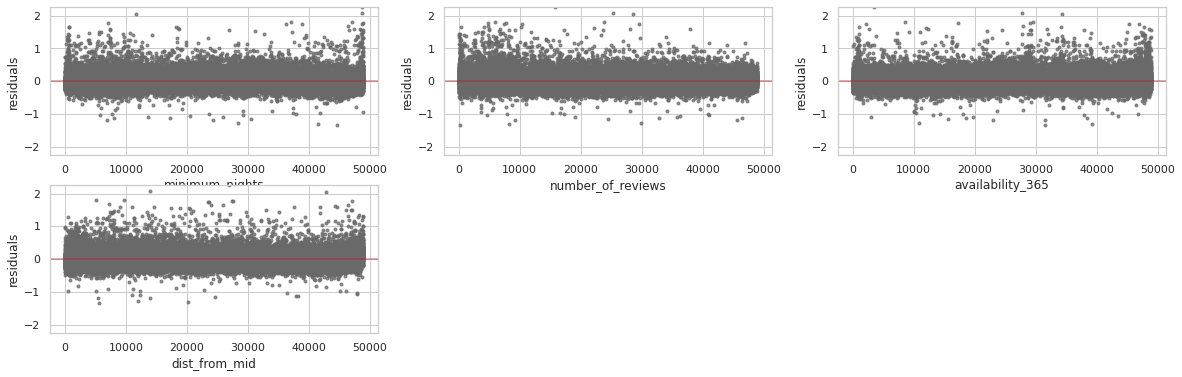

In [ ]:
residuals2 = plot_residuals(result2, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df)

The residuals don't show any clear non-linear behaviors that can be easily identified, perhaps because there is so much data. The most notable pattern is in the number of reviews where there is a lot of overprediction in the early region, which is mostly indicating that the vast majority of our data has a relatively low number of reviews. The residuals with log price are much improved at least, as we aren't predicting over significantly more compared to the non-log model.

We can also compare the histograms of price and log_price versus both residuals:

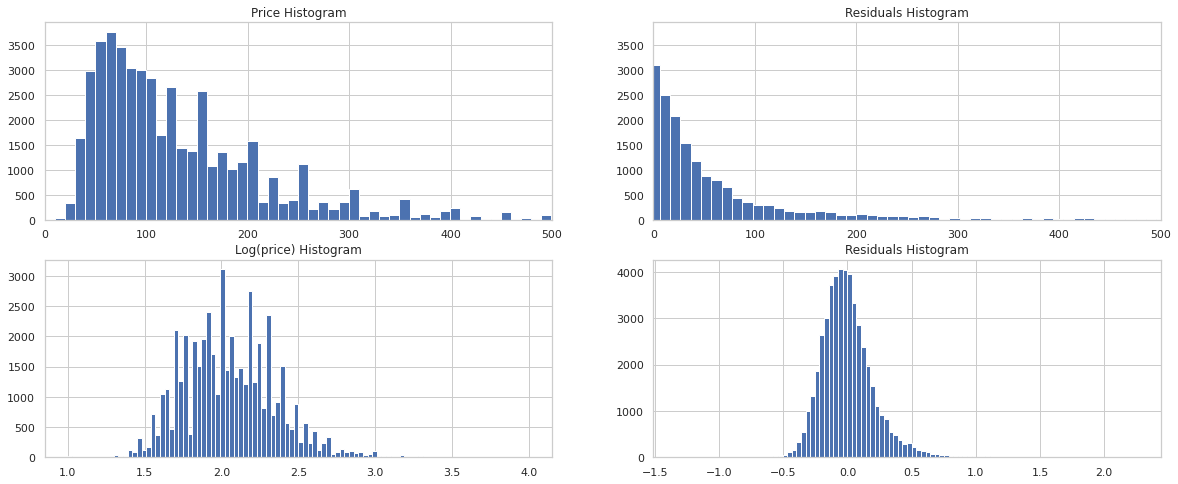

In [ ]:
figure = plt.figure(figsize=(20,8))

axes = figure.add_subplot(2, 2, 1)
axes.hist(df['price'], bins=1000)
axes.set_title("Price Histogram")
axes.set_xlim((0,500))

axes = figure.add_subplot(2, 2, 2)
axes.hist(residuals1, bins=1000)
axes.set_title("Residuals Histogram")
axes.set_xlim((0,500))

axes = figure.add_subplot(2, 2, 3)
axes.hist(df['log_price'], bins=100)
axes.set_title("Log(price) Histogram")

axes = figure.add_subplot(2, 2, 4)
axes.hist(residuals2, bins=100)
axes.set_title("Residuals Histogram")

plt.show()
plt.close()    

The residuals using the log_price is more symmetric than the residuals of the first model. Therefore, the target variable would be the transformed price variable.



Below shows the correlation between the target variable, log_price and the other independent variables:

In [ ]:
correlations(df, "log_price", ["minimum_nights", "number_of_reviews", "availability_365", "host_experience_average", "host_experience_high", "host_experience_low", "neighbourhood_group_Bronx", "neighbourhood_group_Brooklyn", "neighbourhood_group_Manhattan", "neighbourhood_group_Queens", "neighbourhood_group_Staten Island", "dist_from_mid", "entireHomeApt", "privateRoom", "sharedRoom"])

,feature,r,rho
0,minimum_nights,0.033236,0.101330
1,number_of_reviews,-0.042319,-0.054898
2,availability_365,0.098844,0.086175
3,host_experience_average,-0.176320,-0.195750
4,host_experience_high,0.107858,0.112774
5,host_experience_low,0.112552,0.128469
6,neighbourhood_group_Bronx,-0.104469,-0.109570
7,neighbourhood_group_Brooklyn,-0.192086,-0.197252
8,neighbourhood_group_Manhattan,0.348033,0.362154
9,neighbourhood_group_Queens,-0.184525,-0.195438


For variables entireHome/Apt and privateRoom, there is a strong relationship with the target variable, log_price. The spearsman correlation suggests that these relationships might be non-linear. The variable distance_from_mid and neighbourhood_group_Manhattan have almost a medium correlation with target variable. There is no strong relationship between the rest of the variables with log_price. 

**Adding Tranasformed Variables and Interaction Terms to The Model**



To improve the model, we add the squared of non-categorical variables one at a time. The first variable to add is the squared of number_of_reviews:

In [ ]:
df['number_of_reviews_sqr'] = df.number_of_reviews**2

In [ ]:
model = "log_price ~ minimum_nights + number_of_reviews_sqr + availability_365 + host_experience_average + host_experience_low + neighbourhood_group_Bronx + neighbourhood_group_Brooklyn + neighbourhood_group_Manhattan + neighbourhood_group_Queens + dist_from_mid + entireHomeApt + privateRoom"
result3 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result3)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.77,1.74,1.81
minimum_nights,$\beta_{1}$,-0.00,-0.00,-0.00
number_of_reviews_sqr,$\beta_{2}$,-0.00,-0.00,-0.00
availability_365,$\beta_{3}$,0.00,0.00,0.00
host_experience_average,$\beta_{4}$,0.03,0.02,0.04
host_experience_low,$\beta_{5}$,0.04,0.03,0.05
neighbourhood_group_Bronx,$\beta_{6}$,-0.08,-0.10,-0.05
neighbourhood_group_Brooklyn,$\beta_{7}$,-0.06,-0.08,-0.03
neighbourhood_group_Manhattan,$\beta_{8}$,0.03,0.00,0.06


In [ ]:
print(models.adjusted_r_squared(result3))

0.4997677533612107


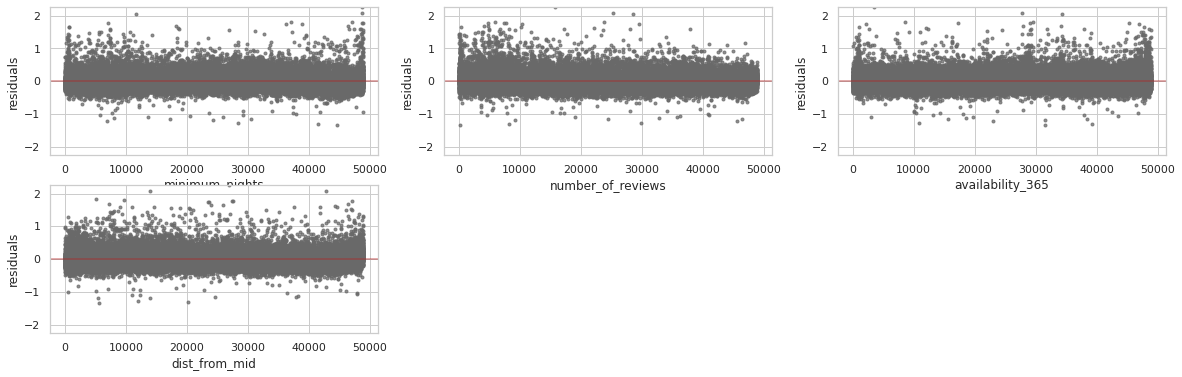

In [ ]:
residuals3 = plot_residuals(result3, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df)

There was no improvement in the model R-squared or the error. The residuals do not show any specific non-linear pattern. Next, we add the squared of the variable availability_365:

In [ ]:
df['availability_365_sqr'] = df.availability_365**2

In [ ]:
model = "log_price ~ minimum_nights + number_of_reviews + availability_365_sqr + host_experience_average + host_experience_low + neighbourhood_group_Bronx + neighbourhood_group_Brooklyn + neighbourhood_group_Manhattan + neighbourhood_group_Queens + dist_from_mid + entireHomeApt + privateRoom"
result4 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.78,1.75,1.81
minimum_nights,$\beta_{1}$,-0.00,-0.00,-0.00
number_of_reviews,$\beta_{2}$,-0.00,-0.00,-0.00
availability_365_sqr,$\beta_{3}$,0.00,0.00,0.00
host_experience_average,$\beta_{4}$,0.04,0.03,0.05
host_experience_low,$\beta_{5}$,0.04,0.03,0.05
neighbourhood_group_Bronx,$\beta_{6}$,-0.08,-0.10,-0.04
neighbourhood_group_Brooklyn,$\beta_{7}$,-0.06,-0.08,-0.04
neighbourhood_group_Manhattan,$\beta_{8}$,0.03,0.01,0.05


In [ ]:
print(models.adjusted_r_squared(result4))

0.49809419941801536


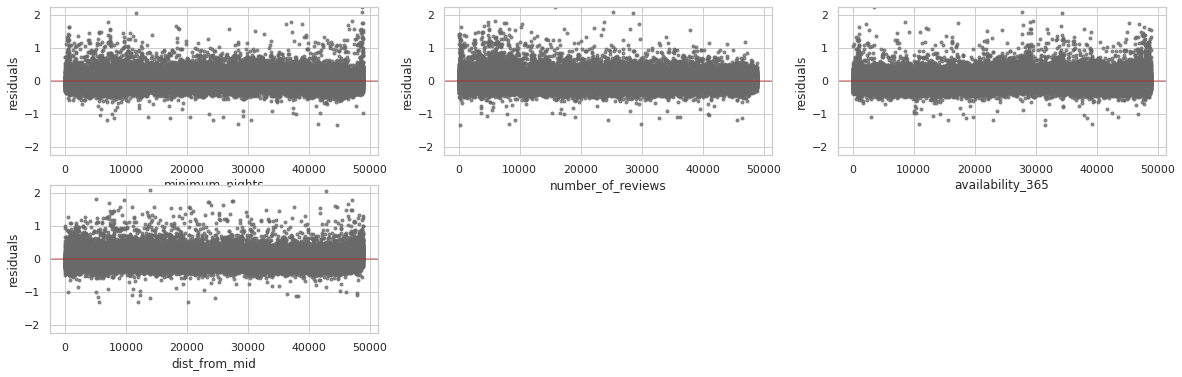

In [ ]:
residuals4 = plot_residuals(result4, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df)

Since there was no improvement in the model metrics or the residuals, we then add the squared of the variable dist_from_mid to the regression model:

In [ ]:
df["dist_from_mid_sqr"] = df.dist_from_mid**2

In [ ]:
model = "log_price ~ minimum_nights + number_of_reviews + availability_365 + host_experience_average + host_experience_low + neighbourhood_group_Bronx + neighbourhood_group_Brooklyn + neighbourhood_group_Manhattan + neighbourhood_group_Queens + dist_from_mid_sqr + entireHomeApt + privateRoom"
result5 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result5)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.64,1.61,1.68
minimum_nights,$\beta_{1}$,-0.00,-0.00,-0.00
number_of_reviews,$\beta_{2}$,-0.00,-0.00,-0.00
availability_365,$\beta_{3}$,0.00,0.00,0.00
host_experience_average,$\beta_{4}$,0.02,0.01,0.03
host_experience_low,$\beta_{5}$,0.03,0.02,0.04
neighbourhood_group_Bronx,$\beta_{6}$,-0.07,-0.10,-0.03
neighbourhood_group_Brooklyn,$\beta_{7}$,-0.01,-0.04,0.02
neighbourhood_group_Manhattan,$\beta_{8}$,0.12,0.09,0.15


In [ ]:
print(models.adjusted_r_squared(result5))

0.48271094841135953


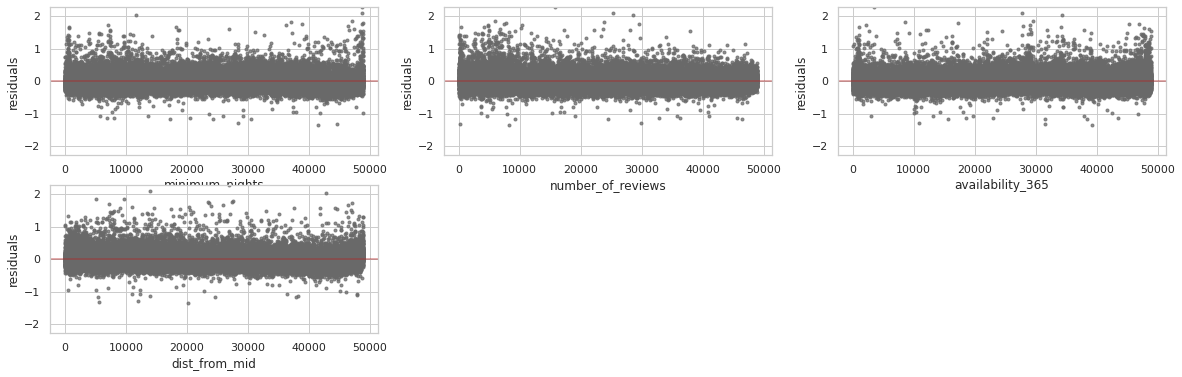

In [ ]:
residuals5 = plot_residuals(result5, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df)

Adding this new term has decreased the R-squared by 2%. Let's see how adding the squared of the variable minimum_nights would affect the model:

In [ ]:
df["minimum_nights_sqr"] = df.minimum_nights**2

In [ ]:
model = "log_price ~ minimum_nights_sqr + number_of_reviews + availability_365 + host_experience_average + host_experience_low + neighbourhood_group_Bronx + neighbourhood_group_Brooklyn + neighbourhood_group_Manhattan + neighbourhood_group_Queens + dist_from_mid + entireHomeApt + privateRoom"
result6 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.76,1.72,1.78
minimum_nights_sqr,$\beta_{1}$,-0.00,-0.00,0.00
number_of_reviews,$\beta_{2}$,-0.00,-0.00,-0.00
availability_365,$\beta_{3}$,0.00,0.00,0.00
host_experience_average,$\beta_{4}$,0.05,0.04,0.06
host_experience_low,$\beta_{5}$,0.06,0.05,0.07
neighbourhood_group_Bronx,$\beta_{6}$,-0.08,-0.10,-0.05
neighbourhood_group_Brooklyn,$\beta_{7}$,-0.06,-0.08,-0.03
neighbourhood_group_Manhattan,$\beta_{8}$,0.03,0.00,0.05


In [ ]:
print(models.adjusted_r_squared(result6))

0.4985671270387685


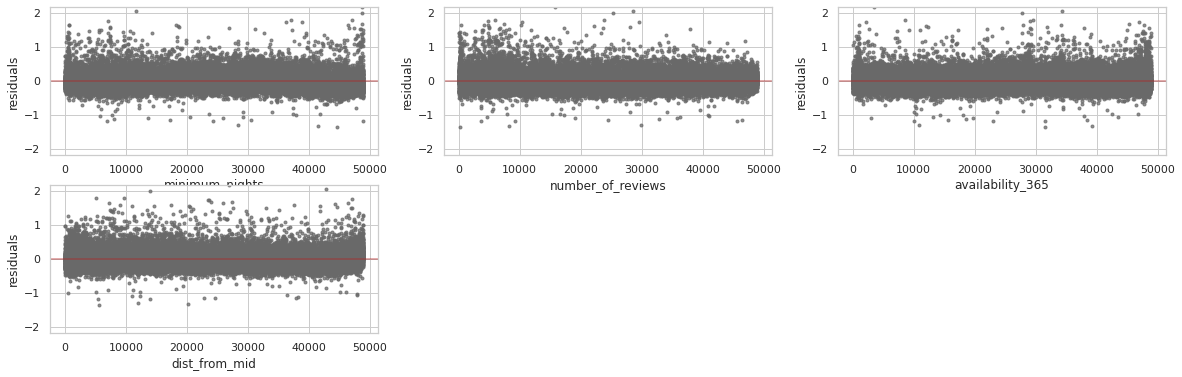

In [ ]:
residuals6 = plot_residuals(result6, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df)

The model R-squared or the residuals have not been improved compared to the previous model. Next, we add 2 dummy variables for cheaper and fancier neighbborhoods based on the mean price in that neighborhood. Listings from the neighborhoods with a mean price under the 25% percentile had cheaphood set to 1; those over 75% percentile had fancyhood set to 1.

In [ ]:
model = "log_price ~ cheaphood + fancyhood + availability_365 + minimum_nights_sqr + number_of_reviews + host_experience_average + host_experience_low  + dist_from_mid + entireHomeApt + privateRoom"
result7 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result7)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.66,1.64,1.68
cheaphood,$\beta_{1}$,-0.11,-0.13,-0.10
fancyhood,$\beta_{2}$,0.13,0.13,0.14
availability_365,$\beta_{3}$,0.00,0.00,0.00
minimum_nights_sqr,$\beta_{4}$,-0.00,-0.00,-0.00
number_of_reviews,$\beta_{5}$,-0.00,-0.00,-0.00
host_experience_average,$\beta_{6}$,0.07,0.05,0.08
host_experience_low,$\beta_{7}$,0.07,0.06,0.08
dist_from_mid,$\beta_{8}$,-1.20,-1.27,-1.13


In [ ]:
print(models.adjusted_r_squared(result7))

0.5122574326951559


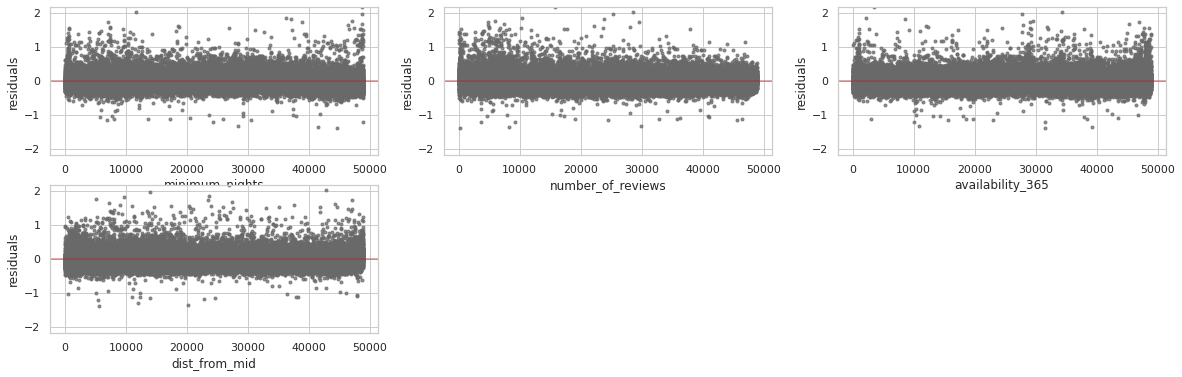

In [ ]:
residuals7 = plot_residuals(result7, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df)

Adding a mean price for the neighborhood instead of the dummy for price extremes improves the model a bit more:

In [ ]:
model = "log_price ~ hood + availability_365 + minimum_nights_sqr + number_of_reviews + host_experience_average + host_experience_low  + dist_from_mid + entireHomeApt + privateRoom"
result8 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result8)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.46,1.44,1.49
hood,$\beta_{1}$,0.00,0.00,0.00
availability_365,$\beta_{2}$,0.00,0.00,0.00
minimum_nights_sqr,$\beta_{3}$,-0.00,-0.00,-0.00
number_of_reviews,$\beta_{4}$,-0.00,-0.00,-0.00
host_experience_average,$\beta_{5}$,0.07,0.07,0.08
host_experience_low,$\beta_{6}$,0.08,0.07,0.09
dist_from_mid,$\beta_{7}$,-0.86,-0.93,-0.79
entireHomeApt,$\beta_{8}$,0.47,0.46,0.49


In [ ]:
print(models.adjusted_r_squared(result8))

0.5335234828980111


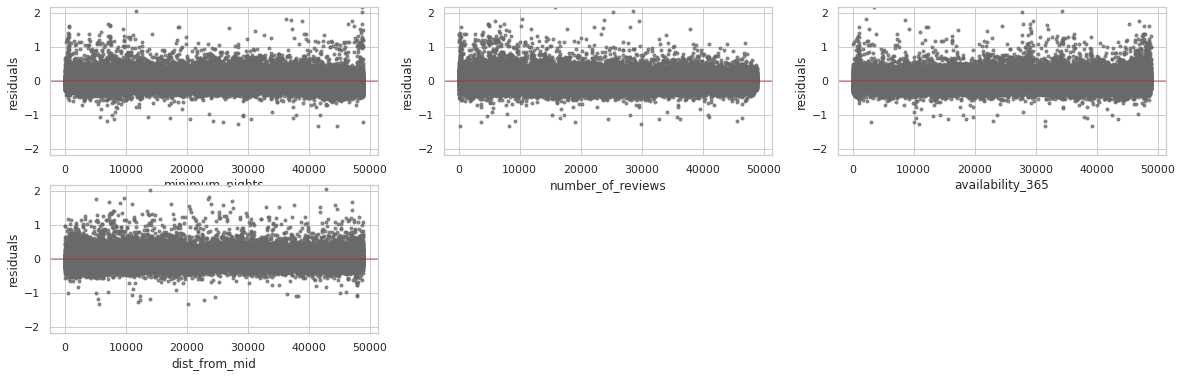

In [ ]:
residuals8 = plot_residuals(result8, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df)

The hood variable has increased the model R-squared to 53.3%. There is no significant change in the residuals plots compared to the previous models. We then need to see how adding the variable reviews_per_month affects the model. The rows with the missing values of reviews_per_month have been dropped from the data.

In [ ]:
df_no_missing = df.dropna()

In [ ]:
model = "log_price ~ reviews_per_month + hood + availability_365 + minimum_nights_sqr + number_of_reviews + host_experience_average + host_experience_low  + dist_from_mid + entireHomeApt + privateRoom"
result9 = models.bootstrap_linear_regression(model, data=df_no_missing)
models.describe_bootstrap_lr(result9)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.46,1.43,1.48
reviews_per_month,$\beta_{1}$,0.00,0.00,0.00
hood,$\beta_{2}$,0.00,0.00,0.00
availability_365,$\beta_{3}$,0.00,0.00,0.00
minimum_nights_sqr,$\beta_{4}$,-0.00,-0.00,-0.00
number_of_reviews,$\beta_{5}$,-0.00,-0.00,-0.00
host_experience_average,$\beta_{6}$,0.07,0.06,0.08
host_experience_low,$\beta_{7}$,0.07,0.05,0.08
dist_from_mid,$\beta_{8}$,-0.94,-1.01,-0.89


In [ ]:
print(models.adjusted_r_squared(result9))

0.5579452932959159


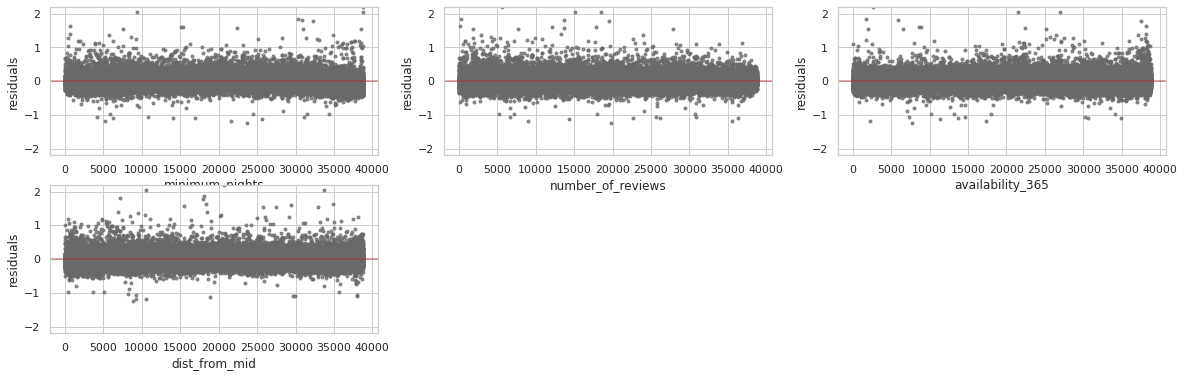

In [ ]:
residuals9 = plot_residuals(result9, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df_no_missing)

Adding the variable reviews_per_month to the model has increased both R-squared and adjusted R-squared to 56%. There is no significant improvement in the residuals plot. Next, we add the count price for the neighborhood to the model:

In [ ]:
model = "log_price ~ hood_count + reviews_per_month + hood + availability_365 + minimum_nights_sqr + number_of_reviews + host_experience_average + host_experience_low  + dist_from_mid + entireHomeApt + privateRoom"
result10 = models.bootstrap_linear_regression(model, data=df_no_missing)
models.describe_bootstrap_lr(result10)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.45,1.42,1.47
hood_count,$\beta_{1}$,0.00,0.00,0.00
reviews_per_month,$\beta_{2}$,0.00,0.00,0.00
hood,$\beta_{3}$,0.00,0.00,0.00
availability_365,$\beta_{4}$,0.00,0.00,0.00
minimum_nights_sqr,$\beta_{5}$,-0.00,-0.00,-0.00
number_of_reviews,$\beta_{6}$,-0.00,-0.00,-0.00
host_experience_average,$\beta_{7}$,0.07,0.06,0.08
host_experience_low,$\beta_{8}$,0.07,0.06,0.08


In [ ]:
print(models.adjusted_r_squared(result10))

0.558084695786466


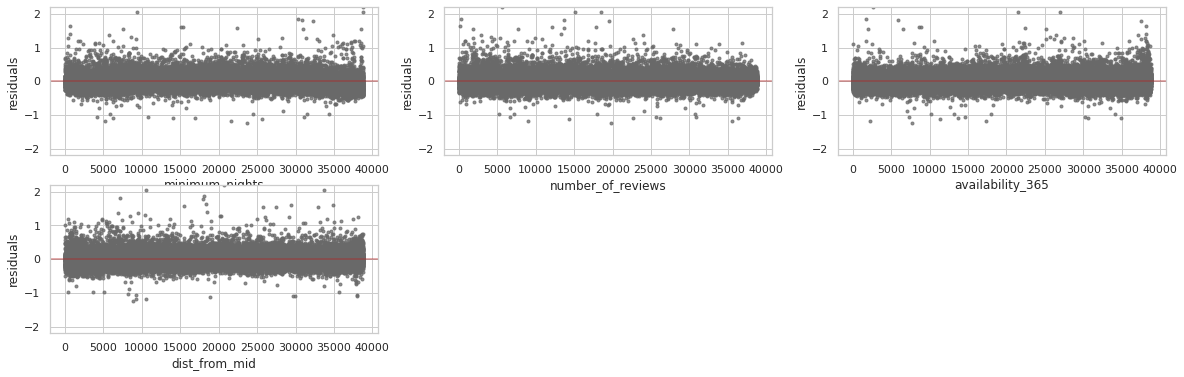

In [ ]:
residuals10 = plot_residuals(result10, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df_no_missing)

There are 293 listings with prices above \$1000 which are mostly related to AirbnbLux and AirbnbPlus. Those listings are abnormally expensive and require some minimum amount of stay in order to make a reservation. In order to boost the accuracy of the prediction using the model, we removed all listings with prices above $1000.

In [ ]:
df_price_below_1000 = df[df["price"]<1000]

In [ ]:
model = "log_price ~ hood_count + hood + availability_365 + minimum_nights + number_of_reviews + host_experience_average + host_experience_low  + dist_from_mid + entireHomeApt + privateRoom"
result11 = models.bootstrap_linear_regression(model, data=df_price_below_1000)
models.describe_bootstrap_lr(result11)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.49,1.47,1.51
hood_count,$\beta_{1}$,0.00,0.00,0.00
hood,$\beta_{2}$,0.00,0.00,0.00
availability_365,$\beta_{3}$,0.00,0.00,0.00
minimum_nights,$\beta_{4}$,-0.00,-0.00,-0.00
number_of_reviews,$\beta_{5}$,-0.00,-0.00,-0.00
host_experience_average,$\beta_{6}$,0.06,0.05,0.07
host_experience_low,$\beta_{7}$,0.06,0.05,0.07
dist_from_mid,$\beta_{8}$,-0.87,-0.95,-0.82


In [ ]:
print(models.adjusted_r_squared(result11))

0.5643778192754231


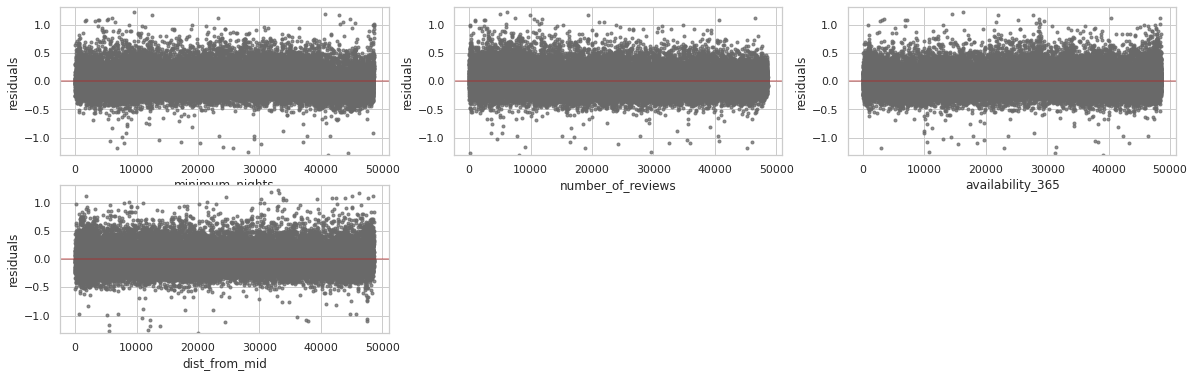

In [ ]:
residuals11 = plot_residuals(result11, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df_price_below_1000)

Removing the listings with price above \$1000 has improved the adjusted R-squared. It seems that the residuals are now more spread out. To further improve the predictive model, we add the variable reviews_per_month and remove the related missing values from the new dataset.

In [ ]:
df_price_below_1000_no_missing = df_no_missing[df_no_missing["price"]<1000]

In [ ]:
model = "log_price ~ reviews_per_month + hood_count + hood + availability_365 + minimum_nights + number_of_reviews + host_experience_average + host_experience_low  + dist_from_mid + entireHomeApt + privateRoom"
result12 = models.bootstrap_linear_regression(model, data=df_price_below_1000_no_missing)
models.describe_bootstrap_lr(result12)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.47,1.45,1.50
reviews_per_month,$\beta_{1}$,0.00,0.00,0.00
hood_count,$\beta_{2}$,0.00,0.00,0.00
hood,$\beta_{3}$,0.00,0.00,0.00
availability_365,$\beta_{4}$,0.00,0.00,0.00
minimum_nights,$\beta_{5}$,-0.00,-0.00,-0.00
number_of_reviews,$\beta_{6}$,-0.00,-0.00,-0.00
host_experience_average,$\beta_{7}$,0.06,0.04,0.07
host_experience_low,$\beta_{8}$,0.06,0.04,0.07


In [ ]:
print(models.adjusted_r_squared(result12))

0.5774870515820036


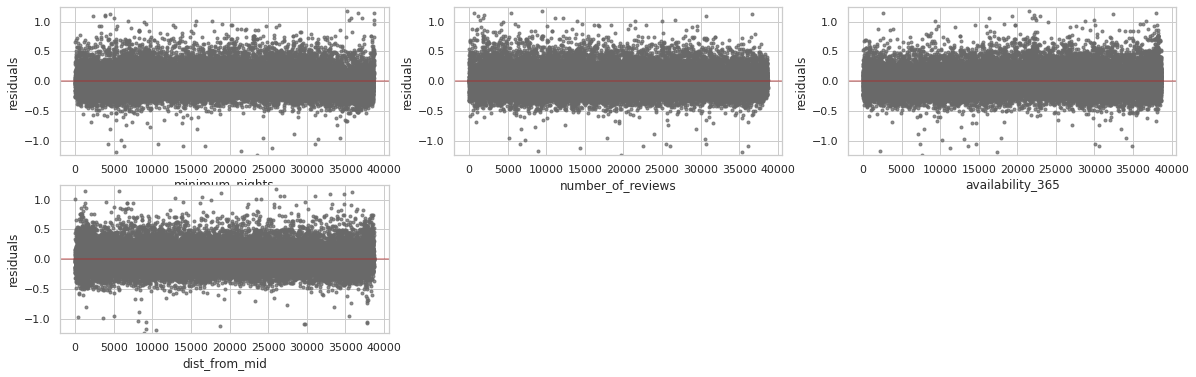

In [ ]:
residuals12 = plot_residuals(result12, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df_price_below_1000_no_missing)

Removing all the outliers, and the rows with missing values have boosted the model. We then Add a column "corrected_minimum_nights" to convert the few listings with minimum_nights > 30 to minimum_nights=30. We use this corrected variable instead of minimum_nights in the model.

In [ ]:
df.corrected_minimum_nights.describe()

count    48884.000000
mean         5.952459
std          8.673930
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max         30.000000
Name: corrected_minimum_nights, dtype: float64

In [ ]:
model = "log_price ~ reviews_per_month + hood_count + hood + availability_365 + corrected_minimum_nights + number_of_reviews + host_experience_average + host_experience_low  + dist_from_mid + entireHomeApt + privateRoom"
result13 = models.bootstrap_linear_regression(model, data=df_price_below_1000_no_missing)
models.describe_bootstrap_lr(result13)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.54,1.52,1.55
reviews_per_month,$\beta_{1}$,-0.00,-0.00,0.00
hood_count,$\beta_{2}$,0.00,0.00,0.00
hood,$\beta_{3}$,0.00,0.00,0.00
availability_365,$\beta_{4}$,0.00,0.00,0.00
corrected_minimum_nights,$\beta_{5}$,-0.01,-0.01,-0.00
number_of_reviews,$\beta_{6}$,-0.00,-0.00,-0.00
host_experience_average,$\beta_{7}$,0.01,0.00,0.02
host_experience_low,$\beta_{8}$,0.01,-0.00,0.02


In [ ]:
print(models.adjusted_r_squared(result13))

0.5881983080644557


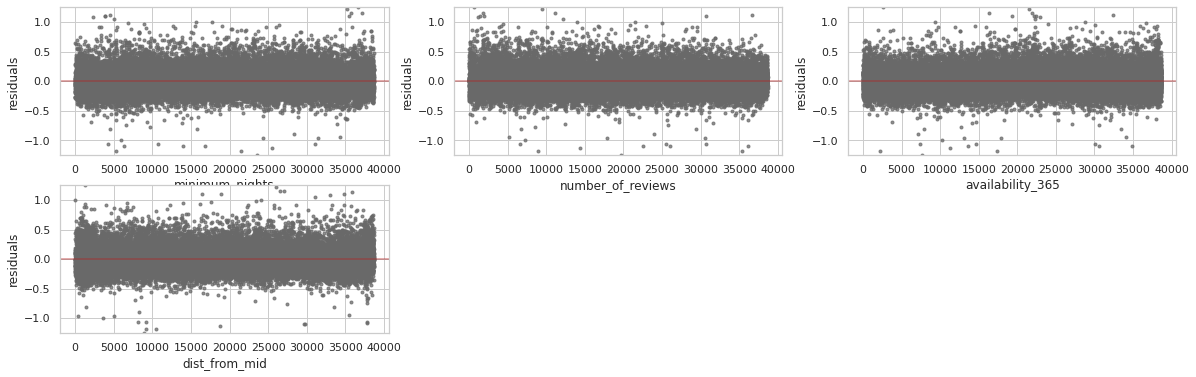

In [ ]:
residuals13 = plot_residuals(result13, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df_price_below_1000_no_missing)

The adjusted R-squared has increased 1%. Now, we Add a new column "corrected_reviews_per_month", where the null values of the variable reviews_per_month are converted to zero. We try using this dataset instead of the previous one where the rows with missing values of reviews_per_month have been removed  

In [ ]:
model = "log_price ~ corrected_reviews_per_month + hood_count + hood + availability_365 + corrected_minimum_nights + number_of_reviews + host_experience_average + host_experience_low  + dist_from_mid + entireHomeApt + privateRoom"
result14 = models.bootstrap_linear_regression(model, data=df_price_below_1000)
models.describe_bootstrap_lr(result14)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.57,1.55,1.59
corrected_reviews_per_month,$\beta_{1}$,-0.01,-0.01,-0.00
hood_count,$\beta_{2}$,0.00,0.00,0.00
hood,$\beta_{3}$,0.00,0.00,0.00
availability_365,$\beta_{4}$,0.00,0.00,0.00
corrected_minimum_nights,$\beta_{5}$,-0.01,-0.01,-0.00
number_of_reviews,$\beta_{6}$,-0.00,-0.00,-0.00
host_experience_average,$\beta_{7}$,0.00,-0.01,0.01
host_experience_low,$\beta_{8}$,-0.00,-0.01,0.01


In [ ]:
print(models.adjusted_r_squared(result14))

0.5768169752051199


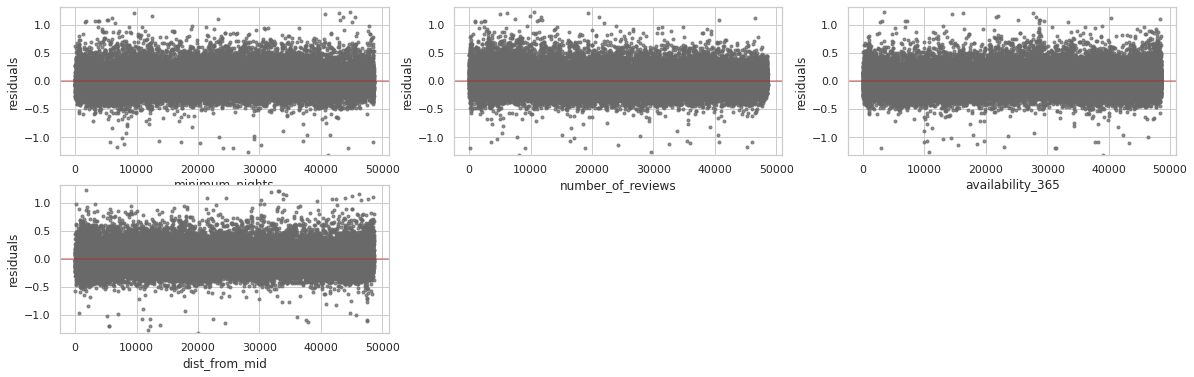

In [ ]:
residuals14 = plot_residuals(result14, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df_price_below_1000)

Converting null values of reviews_per_month to zero reduced the R-squared and had no effect on the residuals. The final model so far is result13.

Next, we add an interaction term for dist_from_mid with the manhattan neighborhood as the point chosen as the mid-point was in Manhattan itself. This should intuitively have some effect as the farther we get away from the middle of Manhattan, the lower the prices tend to get.

In [ ]:
model = "log_price ~ neighbourhood_group_Manhattan:dist_from_mid + reviews_per_month + hood_count + hood + availability_365 + corrected_minimum_nights + number_of_reviews  + dist_from_mid + entireHomeApt + privateRoom"
result15 = models.bootstrap_linear_regression(model, data=df_price_below_1000_no_missing)
models.describe_bootstrap_lr(result15)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.54,1.52,1.56
neighbourhood_group_Manhattan:dist_from_mid,$\beta_{1}$,0.26,0.19,0.32
reviews_per_month,$\beta_{2}$,-0.00,-0.00,0.00
hood_count,$\beta_{3}$,0.00,0.00,0.00
hood,$\beta_{4}$,0.00,0.00,0.00
availability_365,$\beta_{5}$,0.00,0.00,0.00
corrected_minimum_nights,$\beta_{6}$,-0.01,-0.01,-0.00
number_of_reviews,$\beta_{7}$,-0.00,-0.00,-0.00
dist_from_mid,$\beta_{8}$,-0.95,-1.01,-0.89


In [ ]:
print(models.adjusted_r_squared(result15))

0.5886835512719513


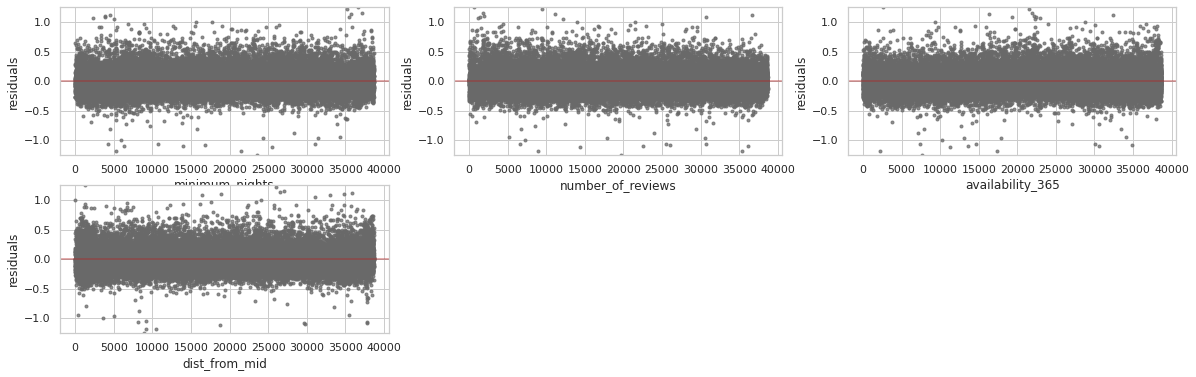

In [ ]:
residuals15 = plot_residuals(result15, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df_price_below_1000_no_missing)

The adjusted R-squared increased only 0.1% which isn't amazing, although the beta value for it is relatively high in magnitude and is quite negative so that is good to see. The residuals look quit good with no non-linear patterns. 

We now add the bedroom variables to the model. 

In [ ]:
model = "log_price ~ RevStudio + Rev1BR + Rev2BR + Rev3BR + neighbourhood_group_Manhattan:dist_from_mid + reviews_per_month + hood_count + hood + availability_365 + corrected_minimum_nights + number_of_reviews  + dist_from_mid + entireHomeApt + privateRoom"
result16 = models.bootstrap_linear_regression(model, data=df_price_below_1000_no_missing)
models.describe_bootstrap_lr(result16)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.57,1.55,1.59
RevStudio,$\beta_{1}$,-0.11,-0.12,-0.11
Rev1BR,$\beta_{2}$,-0.06,-0.06,-0.05
Rev2BR,$\beta_{3}$,0.06,0.05,0.07
Rev3BR,$\beta_{4}$,0.16,0.15,0.17
neighbourhood_group_Manhattan:dist_from_mid,$\beta_{5}$,0.31,0.26,0.36
reviews_per_month,$\beta_{6}$,-0.00,-0.00,-0.00
hood_count,$\beta_{7}$,0.00,0.00,0.00
hood,$\beta_{8}$,0.00,0.00,0.00


In [ ]:
print(models.adjusted_r_squared(result16))

0.6202949644032454


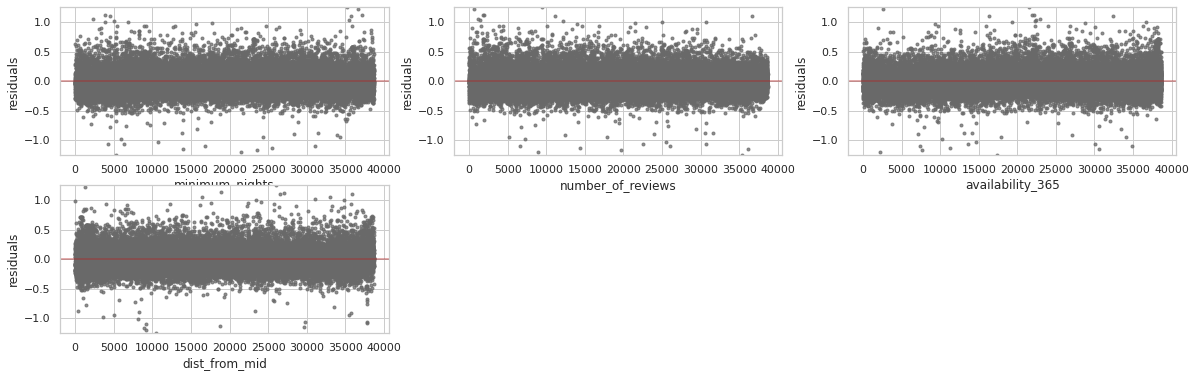

In [ ]:
residuals16 = plot_residuals(result16, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df_price_below_1000_no_missing)

The R-squared has been improved significantly. We now remove the rows with no data for bedroom variables to boost the model more.

In [ ]:
df_price_below_1000_no_missing["sumBR"] = df_price_below_1000_no_missing["RevStudio"] + df_price_below_1000_no_missing["Rev1BR"] + df_price_below_1000_no_missing["Rev2BR"] + df_price_below_1000_no_missing["Rev3BR"] + df_price_below_1000_no_missing["Rev4BR"]
df_br = df_price_below_1000_no_missing[df_price_below_1000_no_missing.sumBR != 0]

In [ ]:
model = "log_price ~ RevStudio + Rev1BR + Rev2BR + Rev3BR + neighbourhood_group_Manhattan:dist_from_mid + reviews_per_month + hood_count + hood + availability_365 + corrected_minimum_nights + number_of_reviews  + dist_from_mid + entireHomeApt + privateRoom"
result17 = models.bootstrap_linear_regression(model, data=df_br)
models.describe_bootstrap_lr(result17)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.83,1.80,1.87
RevStudio,$\beta_{1}$,-0.34,-0.37,-0.31
Rev1BR,$\beta_{2}$,-0.29,-0.32,-0.26
Rev2BR,$\beta_{3}$,-0.17,-0.20,-0.14
Rev3BR,$\beta_{4}$,-0.06,-0.11,-0.03
neighbourhood_group_Manhattan:dist_from_mid,$\beta_{5}$,0.39,0.32,0.46
reviews_per_month,$\beta_{6}$,0.00,-0.00,0.00
hood_count,$\beta_{7}$,-0.00,-0.00,0.00
hood,$\beta_{8}$,0.00,0.00,0.00


In [ ]:
print(models.adjusted_r_squared(result17))

0.6728586571556123


Both R-squared and adjusted R-squared have been increased quite significantly. Let's look at the residuals. 

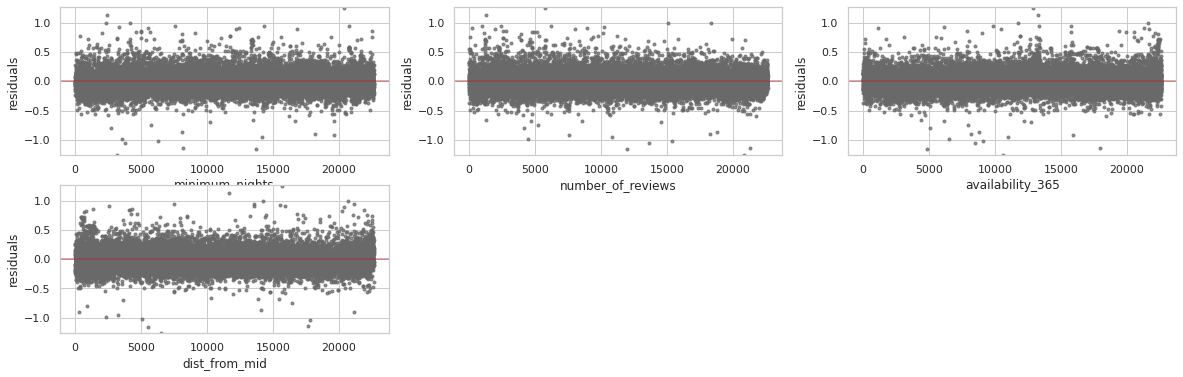

In [ ]:
residuals17 = plot_residuals(result17, ["minimum_nights", "number_of_reviews", "availability_365", "dist_from_mid"], df_br)

The residuals don't show any clear non-linear behaviors or any specific patterns that can be easily identified. This is our final regression model with 67% R-squared.

# 4) Model Evalution



## 10-Fold Cross Validation

In [ ]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [ ]:
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

Below we will run cross validation on the "result17" model

In [ ]:
formula = "log_price ~ RevStudio + Rev1BR + Rev2BR + Rev3BR + neighbourhood_group_Manhattan:dist_from_mid + reviews_per_month + hood_count + hood + availability_365 + corrected_minimum_nights + number_of_reviews  + dist_from_mid + entireHomeApt + privateRoom"

In [ ]:
result_LR_CV = cross_validation(models.linear_regression, formula, df_br, lambda r: (r["sigma"], r["r_squared"]))

In [ ]:
sigmas = [r[0] for r in result_LR_CV]
r_squareds = [r[1] for r in result_LR_CV]

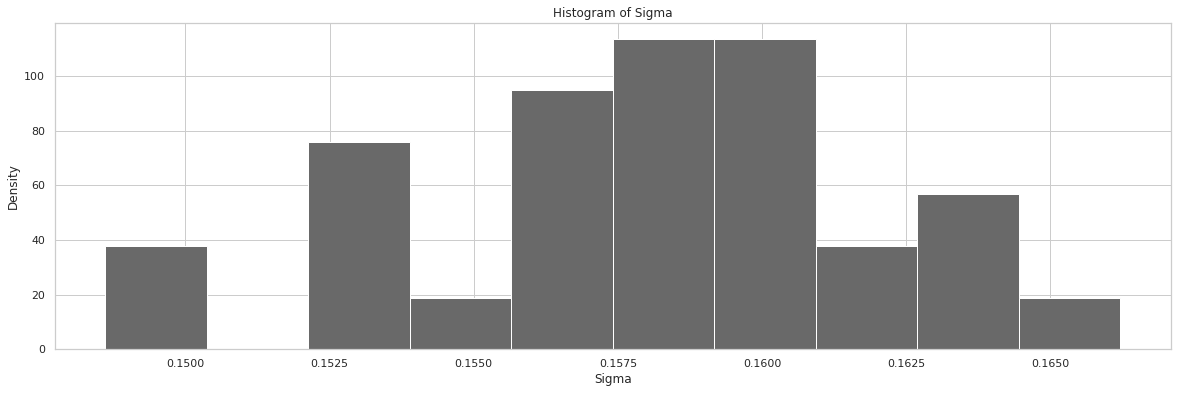

In [ ]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(sigmas, color="DimGray", density=True)
axes.set_xlabel("Sigma")
axes.set_ylabel("Density")
axes.set_title("Histogram of Sigma")

plt.show()
plt.close()

In [ ]:
print("mean sigma: ", np.mean(sigmas))

mean sigma:  0.15781640952106105


The average sigma (standard deviation) for the estimate log-price, based on the model from "results17" is 0.158.

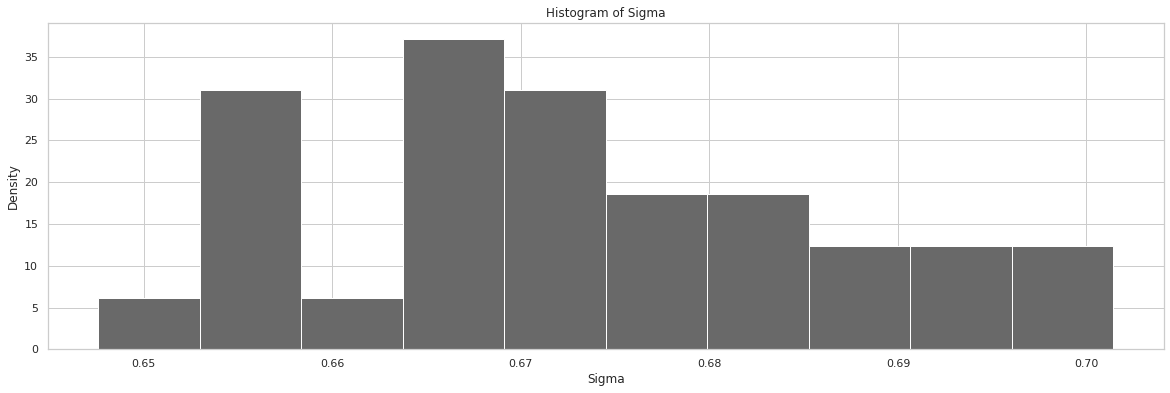

In [ ]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(r_squareds, color="DimGray", density=True)
axes.set_xlabel("Sigma")
axes.set_ylabel("Density")
axes.set_title("Histogram of Sigma")

plt.show()
plt.close()

In [ ]:
print("mean R^2: ", np.mean(r_squareds))

mean R^2:  0.6729085330591661


The average $R^2$ is 0.673, which is exactly the $R^2$ of the original model using all the data as expected.

Next, we determine the credible intervals (CI) for sigma and $R^2$ values collected during the 10-Fold Cross Validation. 

The first 95% CI calculated (below) is the probability that the sigma/$R^2$ value from the 10-Fold Cross Validation falls within the given range.

In [ ]:
print(r"95% CI for sigma:", stats.mstats.mquantiles([r[0] for r in result_LR_CV], [0.025, 0.975]))

95% CI for sigma: [0.14878164 0.16578135]


In [ ]:
print(r"95% CI for R^2:", stats.mstats.mquantiles([r[1] for r in result_LR_CV], [0.025, 0.975]))

95% CI for R^2: [0.64846397 0.70076615]


The 95% CI for sigma is 0.149-0.166 and the 95% CI for $R^2$ is 0.648 - 0.701 from the 10-Fold Cross Validation.


The next 95% CI is the ***mean*** sigma and $R^2$. This value provides the average performance of the model.

Function to perform Bootstap:

In [ ]:
def resample(data):
    n = len(data)
    return [data[ i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

In [ ]:
bootstrap = {}
bootstrap["sigma"] = np.array([np.mean(s) for s in [resample(sigmas) for i in range( 0, 1000)]])
bootstrap["r_squared"] = np.array([np.mean(r) for r in [resample(r_squareds) for i in range( 0, 1000)]])

In [ ]:
print(r"95% CI for *mean* sigma:", stats.mstats.mquantiles(bootstrap["sigma"], [0.025, 0.975]))

95% CI for *mean* sigma: [0.15627173 0.15922037]


In [ ]:
print(r"95% CI for *mean* R^2:", stats.mstats.mquantiles(bootstrap["r_squared"], [0.025, 0.975]))

95% CI for *mean* R^2: [0.66783886 0.67813784]


The 95% CI for sigma is 0.156 -0.159 and the 95% CI for $R^2$ is 0.668 - 0.678 for the ***average performance*** of the model.

This is a much tighter range, than seen with the 95% CI performed simply on the 10-Fold Cross Validation data. 

## Learning Curves ##

The fuctions used for Learning Curves below:

In [ ]:
from collections import defaultdict

In [ ]:
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

In [ ]:
def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=10):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results
#

For the learning curve, the same formula used in the 10-Fold Cross Validation (above) was used.

Additionally, for the learning curve, we observed sigma (standard deviation). 

In [ ]:
result = learning_curves(models.linear_regression, formula, df_br, lambda r: r["sigma"])

In [ ]:
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

In [ ]:
def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()

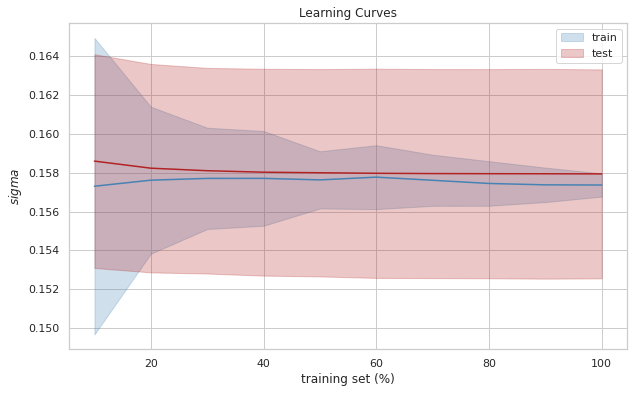

In [ ]:
plot_learning_curves(result, r"$sigma$")

The learning curves have converged to indicate a high bias situation with sigma being around ~.158. We can see that adding more data most likely will not improve our model, so to improve the error we would have to determine further transformations or use a different model entirely.

# 5) Machine Learning Algorithms


## kNN

We can try using kNN directly on the dataset with the same model as result17. Starting with some validation curves to get a good k value then we'll look at a cross validation of a chosen k value to see how good the kNN model works. For comparison, we would look for an $R^2$ value greater than .62. Since there is a competitive aspect to pricing for airbnb, we may be able to get a better model than the linear regression when taking account for prices and parameters of nearby listings. 

In [ ]:
from sklearn.preprocessing import StandardScaler
import sklearn.neighbors as neighbors

formula = "log_price ~ RevStudio + Rev1BR + Rev2BR + Rev3BR + neighbourhood_group_Manhattan:dist_from_mid + reviews_per_month + hood_count + hood + availability_365 + corrected_minimum_nights + number_of_reviews  + dist_from_mid + entireHomeApt + privateRoom"
columns = ['reviews_per_month', 'number_of_reviews', 'dist_from_mid']
scaler = StandardScaler();
df_br[columns] = scaler.fit_transform(df_br[columns]);


In [ ]:
def dmatrix_to_array(dmatrix):
    return np.array([row[0] for row in dmatrix])

In [ ]:
def knn_cross_validation(formula, builder, data, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = {"train": [], "test": []}
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            # y, X for training data
            y, X = patsy.dmatrices(formula, train_data, return_type="matrix")
            model = builder.fit(X, y)
            y_hat = model.predict(X)
            training_r_squared = (stats.pearsonr(dmatrix_to_array(y), dmatrix_to_array(y_hat))[0])**2
            metrics["train"].append(training_r_squared)
            # y, X for test data
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            ys = [el[0] for el in y]
            y_hat = model.predict(X)
            test_r_squared = (stats.pearsonr(dmatrix_to_array(y), dmatrix_to_array(y_hat))[0])**2
            metrics["test"].append(test_r_squared)
    return metrics

In [ ]:
test_curve = []
train_curve = []
for k in range(1, 21):
    builder = neighbors.KNeighborsRegressor(k)
    results = knn_cross_validation(formula, builder, df_br)
    test_curve.append(stats.mstats.mquantiles(results['test'], [0.025, 0.5, 0.975]))
    train_curve.append(stats.mstats.mquantiles(results['train'], [0.025, 0.5, 0.975]))

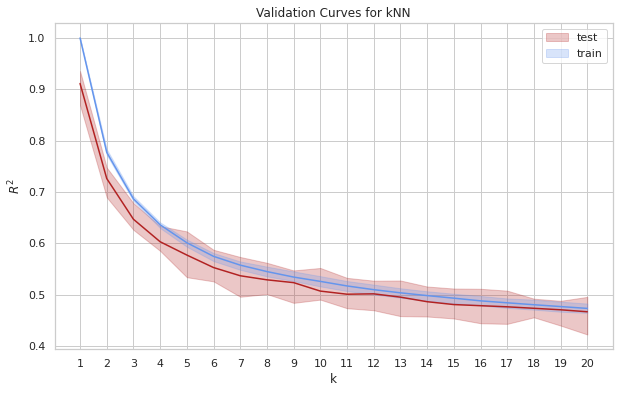

In [ ]:
xs = list(range(1, 21))
figure = plt.figure(figsize=(10, 6)) # first element is width, second is height.
axes = figure.add_subplot(1, 1, 1)

test_lower, test_mid, test_upper = zip(*test_curve)
train_lower, train_mid, train_upper = zip(*train_curve)

axes.fill_between(xs, test_lower, test_upper, alpha=0.25, color="firebrick", label="test")
axes.plot(xs, test_mid, color="firebrick")

axes.fill_between(xs, train_lower, train_upper, alpha=0.25, color="cornflowerblue", label="train")
axes.plot(xs, train_mid, color="cornflowerblue")

axes.set_xticks(xs)
axes.set_xticklabels([str(x) for x in xs])

axes.legend()
axes.set_title("Validation Curves for kNN")
axes.set_xlabel("k")
axes.set_ylabel("$R^2$")

plt.show()
plt.close()

For this model it looks like we should use a k value of 1 although the curves dont converge until k = 6. At k=6 the $R^2$ value is below .6 however, which is worse than our linear regression model. We'll do some cross-validation on k=1 and k=6 to get a concrete idea of the $R^2$.

In [ ]:
builder = neighbors.KNeighborsRegressor(1)
knn_result = knn_cross_validation(formula,builder,df_br)

In [ ]:
print(r"95% CI for R^2:", stats.mstats.mquantiles(knn_result['test'], [0.025, 0.975]))

95% CI for R^2: [0.87422859 0.93155866]


In [ ]:
builder = neighbors.KNeighborsRegressor(6)
knn_result = knn_cross_validation(formula,builder,df_br)

In [ ]:
print(r"95% CI for R^2:", stats.mstats.mquantiles(knn_result['test'], [0.025, 0.975]))

95% CI for R^2: [0.53213375 0.57542477]


The k value of 1 clearly has the best $R^2$ so far, but we need to make sure it isn't over fitting the data. We can check this by doing learning curves and comparing that to the model with k value of 6.

In [ ]:
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

In [ ]:
def knn_learning_curves(builder, formula, data, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                y, X = patsy.dmatrices(formula, train_data_chunk, return_type="matrix")
                model = builder.fit(X, y)
                y_hat = model.predict(X)
                training_r_squared = (stats.pearsonr(dmatrix_to_array(y), dmatrix_to_array(y_hat))[0])**2
                results["train"][i].append(training_r_squared)
                
                # y, X for test data
                y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
                y_hat = model.predict(X)
                test_r_squared = (stats.pearsonr(dmatrix_to_array(y), dmatrix_to_array(y_hat))[0])**2
                results["test"][i].append(test_r_squared)
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results
#

In [ ]:
knn_result_lc = knn_learning_curves(neighbors.KNeighborsRegressor(1), formula, df_br)

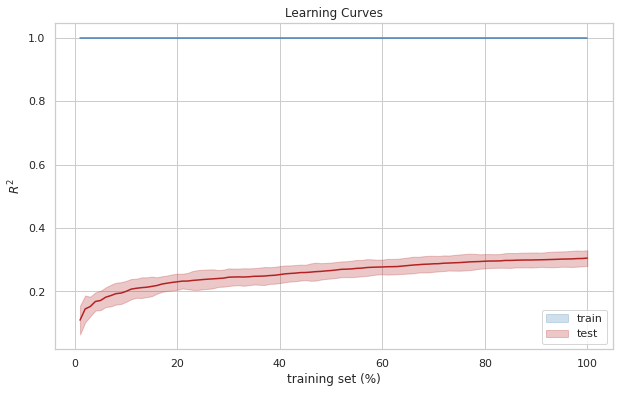

In [ ]:
plot_learning_curves(knn_result_lc, "$R^2$")

Clearly, the k value of 1 results in over fitting as the learning curves don't get close to intersecting. As a result it would not be advisable to use the k=1 model for prediction.

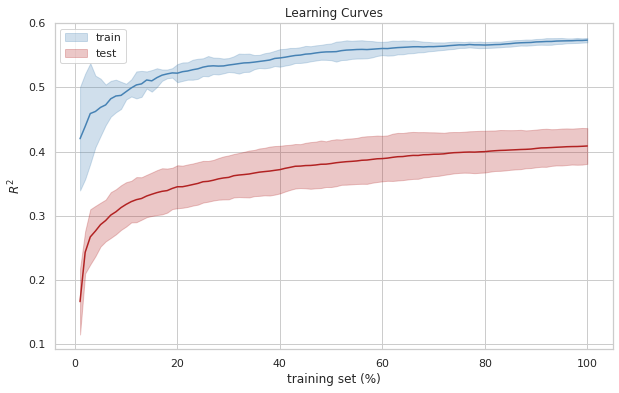

In [ ]:
knn_result_lc = knn_learning_curves(neighbors.KNeighborsRegressor(6), formula, df_br)
plot_learning_curves(knn_result_lc, "$R^2$")

It appears that the kNN model doesn't have learning curves converge with k = 6 either. Increasing k would decrease the $R^2$ further than .5, so even if we do end up with a well trained model, the $R^2$ would be lower than the linear regression and thus not preferable.

## Random Forest

A random forest may be a better predictor using the same formula as it more thoroughly vets the chosen variables.

In [ ]:
from sklearn.model_selection import train_test_split
np.random.seed(101)
random.seed(101)
formula = "log_price ~ RevStudio + Rev1BR + Rev2BR + Rev3BR + neighbourhood_group_Manhattan:dist_from_mid + reviews_per_month + hood_count + hood + availability_365 + corrected_minimum_nights + number_of_reviews  + dist_from_mid + entireHomeApt + privateRoom"

# Train, test, split the data
y, X = patsy.dmatrices(formula, df_br, return_type="matrix")
y=np.ravel(y)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

from sklearn.ensemble import RandomForestRegressor

rfc=RandomForestRegressor(random_state=101)

#Train the model using the training sets 
rfc.fit(X_train,y_train)

# Print Evaluation Metrics
print('Decision Tree Regressor,  R^2: %f' % rfc.score(X_test, y_test))

Decision Tree Regressor,  R^2: 0.710203


An initial random forest model using the same variables as result17 gives an $R^2 = .644$ which is slightly higher than the 95% CI for the linear regression model (.615 - .624). We can try tuning hyper parameters to improve $R^2$.

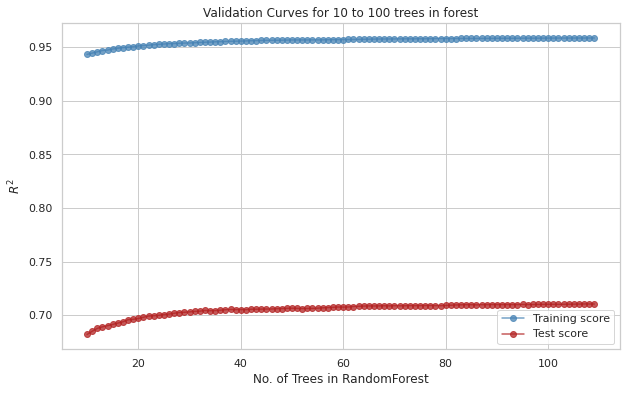

In [ ]:
def r2_validation_curve(seed, X, y, min_val, max_val, step, test_size=0.30):
    train_scores = []
    test_scores = []
    
    for i in range(min_val, max_val + 10):
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        reg = RandomForestRegressor(random_state=seed, n_estimators=i)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_train)
        train_scores.append(reg.score(X_train, y_train))
        y_pred = reg.predict(X_test)
        test_scores.append(reg.score(X_test, y_test))
    return train_scores, test_scores

seed = 101
min_val = 10
max_val = 100
step = 10
param_range = range(min_val, max_val + step)
x_label = 'No. of Trees in RandomForest'
y_label = '$R^2$'
title = "Validation Curves for {0} to {1} trees in forest".format(min_val, max_val)

train_scores, test_scores = r2_validation_curve(seed, X, y, min_val, max_val, step=200)

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot(param_range, train_scores, 'o-', color="steelblue", alpha=0.75, label="Training score")
axes.plot(param_range, test_scores, "o-", color="firebrick", alpha=0.75, label="Test score")
axes.set_xlabel(x_label)
axes.set_ylabel(y_label)
axes.set_title(title)
plt.legend(loc="best")
plt.show()
plt.close()

It does not appear that increasing the number of trees will improve $R^2$ as the values appear to have converged. We can look at modifying the max depth to atleast improve the efficiency of the model.

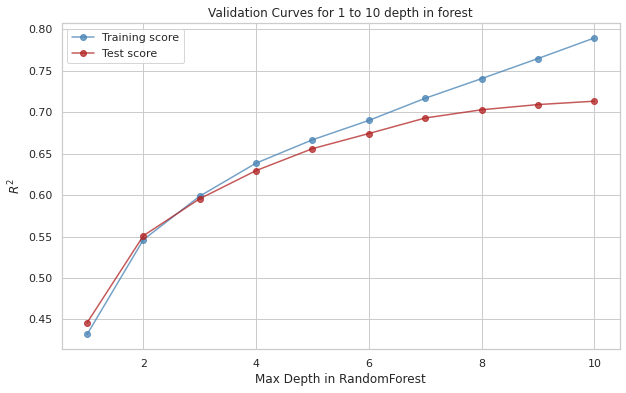

In [ ]:
def depth_validation_curve(seed, X, y, min_val, max_val, step, test_size=0.30):
    train_scores = []
    test_scores = []
    
    for i in range(min_val, max_val+1):
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        reg = RandomForestRegressor(random_state=seed, max_depth=i)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_train)
        train_scores.append(reg.score(X_train, y_train))
        y_pred = reg.predict(X_test)
        test_scores.append(reg.score(X_test, y_test))
    return train_scores, test_scores

seed = 101
min_val = 1
max_val = 10
step = 1
param_range = range(min_val, max_val + step)
x_label = 'Max Depth in RandomForest'
y_label = '$R^2$'
title = "Validation Curves for {0} to {1} depth in forest".format(min_val, max_val)

train_scores, test_scores = depth_validation_curve(seed, X, y, min_val, max_val, step=200)

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot(param_range, train_scores, 'o-', color="steelblue", alpha=0.75, label="Training score")
axes.plot(param_range, test_scores, "o-", color="firebrick", alpha=0.75, label="Test score")
axes.set_xlabel(x_label)
axes.set_ylabel(y_label)
axes.set_title(title)
plt.legend(loc="best")
plt.show()
plt.close()

Here we can see that the max depth could be set to 6 before the curves significantly diverge.

In [ ]:
def rf_cross_validation(formula, builder, data, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = {"train": [], "test": []}
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            # y, X for training data
            y, X = patsy.dmatrices(formula, train_data, return_type="matrix")
            y = np.ravel(y)
            model = builder.fit(X, y)
            y_hat = model.predict(X)
            training_r_squared = (stats.pearsonr(y, y_hat)[0])**2
            metrics["train"].append(training_r_squared)
            # y, X for test data
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            y = np.ravel(y)
            y_hat = model.predict(X)
            test_r_squared = (stats.pearsonr(y, y_hat)[0])**2
            metrics["test"].append(test_r_squared)
    return metrics

In [ ]:
builder = RandomForestRegressor(random_state = 101, max_depth=6)
rf_result = rf_cross_validation(formula, builder, df_br)

In [ ]:
print(r"95% CI for R^2:", stats.mstats.mquantiles(rf_result['test'], [0.025, 0.975]))
print(r"Mean for R^2:", np.mean(rf_result['test']))

95% CI for R^2: [0.66396473 0.71380497]
Mean for R^2: 0.686857023060812


With a max_depth of 6 we are able to achieve a mean $R^2$ of .63 with a wider 95%CI than the linear regression. The mean $R^2$ is only a little bit higher than our linear model.

## Bayseian Inference ##

Using Bayseian Inference, the Random Forest model will be compared to the Linear Regression model.

Linear Regression used:Cross Validation results from **result17**, "result_LR_CV"

From the Random Forest set above, cross validation was performed (below).

In [ ]:
from sklearn import model_selection

In [ ]:
dt_results = []
for i in range(0, 3):
    kfold = model_selection.KFold(n_splits=10, random_state=101)

    #Train the model using the training sets 
    regressor = RandomForestRegressor(random_state=101, max_depth=6)
    regressor.fit(X_train,y_train)
    results = model_selection.cross_val_score(regressor, X, y, cv=kfold)
    dt_results = np.concatenate((dt_results, results), axis=None)

In [ ]:
np.mean(dt_results)

0.6554774440487516

The mean $R^2$ results, for the Random Forest 10-Fold Cross Validation is 0.655. 

This value is actually lower than the mean $R^2$ value of the Linear Regression model, 0.673.

Function for performing Bootstrap:

In [ ]:
def bootstrap_sample( data, f, n=100):
    result = []
    m = len( data)
    for _ in range( n):
        sample = np.random.choice( data, len(data), replace=True)
        r = f( sample)
        result.append( r)
    return np.array( result)

In [ ]:
lr_bootstrap = bootstrap_sample([r[1] for r in result_LR_CV], np.mean)
dt_bootstrap = bootstrap_sample(dt_results, np.mean)
difference = dt_bootstrap - lr_bootstrap

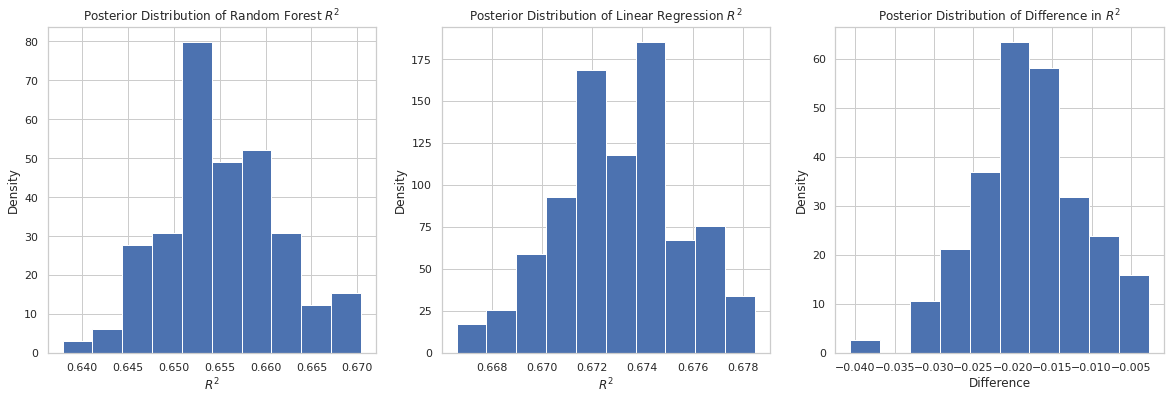

In [ ]:
figure = plt.figure(figsize=(20, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 3, 1)

axes.hist(dt_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of Random Forest $R^2$")

axes = figure.add_subplot(1, 3, 2)

axes.hist(lr_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of Linear Regression $R^2$")

axes = figure.add_subplot(1, 3, 3)

axes.hist( difference, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Difference")
axes.set_title( "Posterior Distribution of Difference in $R^2$")

plt.show()
plt.close()

In [ ]:
print("P(RF > LR)", np.mean(difference >= 0))
print("P(LR > RF)", np.mean(difference < 0))

P(RF > LR) 0.0
P(LR > RF) 1.0


100% of the time, the $R^2$ value for the Linear Regression is larger than the $R^2$ of the Random Forest.

Therefore, when moving forward the team would recommend using the Linear Regression model, as it will provide the best predictive price value. 